In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps

from matplotlib.gridspec import GridSpec

# stel de logger in om alleen foutmeldingen naar het scherm te printen
ps.set_log_level("ERROR")

# print de versies van belangrijke Python packages voor pastas
# ps.show_versions(numba=True)

%config InlineBackend.figure_format = 'retina'
ps.show_versions()

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Pastas version: 1.9.0
Python version: 3.11.4
NumPy version: 1.24.3
Pandas version: 2.2.2
SciPy version: 1.10.1
Matplotlib version: 3.7.1
Numba version: 0.57.0


# Model Structure

An important step in time series analysis is determining the model structure of the time series model. In this notebook, we limit ourselves to determining the deterministic part of the model. The determination of the noise model is covered in the notebook on model calibration. This notebook provides an overview of the various options available for defining the model structure.

**Table of Contents**

- [Basic model structure](#Basic-model-structure)
- [Response functions](#Response-functions)
- [Effect of precipitation and evaporation](#Effect-of-precipitation-and-evaporation)
- [Threshold non-linearity](#Threshold-non-linearity)
- [Other explanatory variables](#Other-explanatory-variables)
- [Changes in the system](#Changes-in-the-system)
- [Discussion](#Discussion)

## General Step-by-Step Plan
To choose the desired model structure, it is important to define the objective of the time series modeling. Once the goal of the modeling is clear, the following steps can be followed:

1. **System analysis**: identify potential hydrological variables,
2. **Model construction**: determine how these variables are translated into fluctuations,
3. **Validation**: determine which variables actually have an effect.

We assume that the first step has already been completed and we will discuss the second step here. This notebook provides an overview of the building blocks available for constructing a model. The final step, validation, is covered in the notebook on *Model Evaluation*.


## Basic Model Structure

The time series model can be described in its most general form as follows:

$$ h(t) = \sum_{m=1}^M h_m(t) + d + r(t) $$

where $h(t)$ is the observed groundwater head, $h_m(t)$ is the contribution of influence $m$, $d$ is the base level of the model, and $r(t)$ represents the model residuals. The total number of influences contributing to groundwater head fluctuations is $M$. This notebook mainly focuses on determining these contributions, but first a brief explanation is given about the base level $d$.

### The Base Level of the Model

Almost every time series model includes a constant (here parameter $d$) that brings the model to the correct level. Although tempting, it is not always correct to assign a physical meaning to this constant. In the literature, it is sometimes referred to as the drainage base — the level to which the groundwater eventually returns when all influences are zero. Whether this interpretation is valid depends on the model. It is therefore safer to refer to $d$ simply as the base level of the model.

There are several methods available to determine the value of the base level. One option is to take the mean of the residuals after a simulation and use this as the value for $d$. This means that parameter $d$ does not need to be estimated during calibration. Another option is to estimate $d$ as a parameter ([Collenteur et al. 2019](#References)). The advantage of this is that it also allows estimation of the uncertainty associated with this parameter. The effect of these two methods on the final results is still unclear.

For the examples in this notebook, whether or not the constant is included in the fit makes little difference to the results. This can be tested by setting the variable `fit_constant` to `True` or `False` in the following code block (note: code blocks are not displayed in the PDF version of this notebook). In the rest of this notebook, the base level $d$ is estimated during calibration.


In [2]:
fit_constant = True

### Contributions

Fluctuations in the groundwater head can arise from various causes. Often, we have an idea of which variables are important, but just as often, identifying these causes is the very goal of the modeling process. The calculated effect of a certain influence will to some extent depend on the chosen modeling approach — in other words, the way in which an influence is translated into a contribution to groundwater head fluctuations. The choice of model structure can therefore affect the model results.

We can roughly distinguish between two types of influences: measured and unmeasured influences. For measured influences, explanatory time series are available to determine their contribution to groundwater head fluctuations. These include, for example: precipitation, potential evaporation, extractions, surface water levels, and atmospheric pressure measurements. This type of influence can be translated into a contribution to head fluctuations using an impulse response function.

For unmeasured influences, explanatory time series are often not available, and the effect of these types of influences is more difficult to determine. Examples include changes in land use and interventions in water management (e.g., filling in a ditch or dredging a canal). Some of these contributions can be accounted for by including a trend in the model. The information that the modeler must then provide is a time period or a specific moment when the change occurred.

## Response Functions

The translation of an explanatory time series into a contribution to groundwater head fluctuations can be done using an impulse response function [(see also von Asmuth et al., 2002)](#References). The impulse response function describes how the groundwater head responds to an impulse in the explanatory variable. There are many response functions to choose from to convert an explanatory time series into a contribution to head fluctuations. The choice of a specific response function may depend on the type of explanatory variable (e.g., precipitation or river water level), but also on the system (e.g., a thick or thin unsaturated zone).

Often, a general response function with four parameters or a simplified version of it is used as the impulse response function. Depending on the system, some parameters can be fixed, reducing the number of parameters that need to be estimated. The following figure shows three impulse response functions that are each simplified versions of the 4-parameter function: Exponential, Gamma, and Hantush.

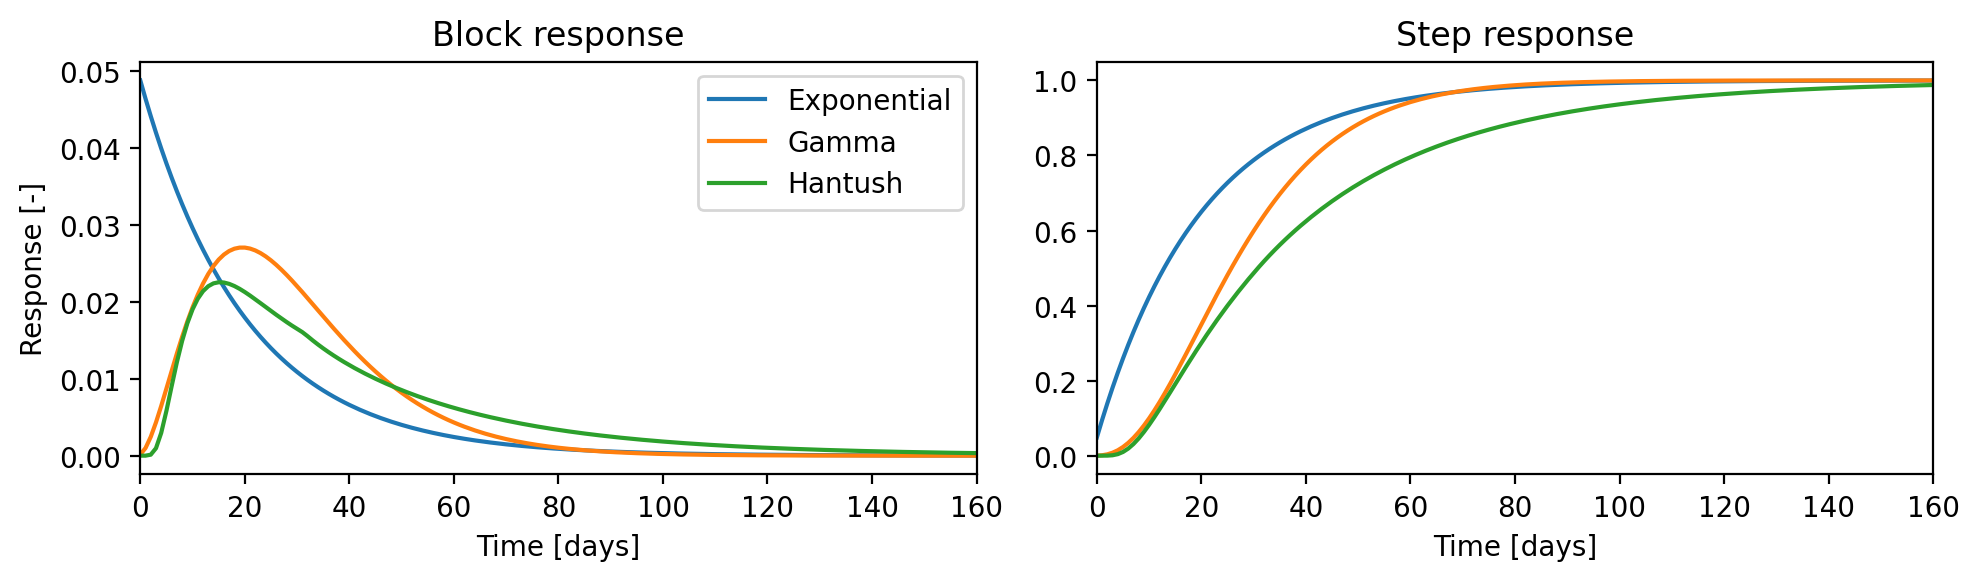

In [3]:
# Example of Gamma response function where n=1, and the same model with an exponential function

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 3), sharex=True)

rfuncs = [ps.Exponential(), ps.Gamma(), ps.Hantush()]
params = [[1, 20], [1, 3, 10], [1, 45, 0.5]]

for rfunc, param in zip(rfuncs, params):
    rfunc.up = True
    ax1.plot(rfunc.block(param, cutoff=0.99999))
    ax2.plot(rfunc.step(param, cutoff=0.99999))

ax1.set_xlim(0, 160)
ax1.set_title("Block response")
ax2.set_title("Step response")
ax1.set_xlabel("Time [days]")
ax2.set_xlabel("Time [days]")
ax1.set_ylabel("Response [-]")
ax1.legend(["Exponential", "Gamma", "Hantush"])
plt.tight_layout()


The Exponential response function has 2 parameters, while the Gamma and Hantush response functions each have 3 parameters. As shown in the figure above, the additional parameter in the Gamma and Hantush functions helps simulate a greater delay in the groundwater head response. 

It may happen that, after calibration, the parameters of the Gamma response function effectively simulate an Exponential response. In such cases, it is possible to fix certain parameters or switch to a different response function, thereby reducing the number of parameters to be estimated. In general, it is preferable to choose the response function with fewer parameters if the model fit is similar.

Although the name "Hantush" suggests that the parameters can be interpreted physically, the validity of such an interpretation depends on the local soil profile and how well it aligns with the assumptions of the Hantush function. It is also recommended to test various response functions. This will be done multiple times throughout this notebook. Which response functions are available depends on the software package being used.

## Effect of Precipitation and Evaporation

Almost all groundwater levels in the Netherlands are influenced to some degree by precipitation and evaporation. These two explanatory time series are therefore almost always included in a time series model. However, the way in which these series are incorporated into the model can vary significantly. We can roughly distinguish four methods:

- Precipitation and evaporation as separate influences with separate response functions  
- Net precipitation surplus ($N = P - fE$) with one response function  
- Non-linear groundwater recharge with one response function  
- Direct input of the groundwater recharge with one response function  

In the next three sections, models will be created using the first three methods to model the effect of precipitation and evaporation. The last method is not shown here but can easily be applied. In that method, groundwater recharge or net precipitation surplus is calculated outside of the time series modeling (e.g., using a SWAP or Hydrus-1D model), and this series is then used as input and translated with a response function.

### Example Data

The groundwater head time series used in this example was measured in observation well B32C0639 (screen 1) near De Bilt. Precipitation and potential Makkink evaporation are available from the KNMI meteorological station in De Bilt. The figure below shows the measured groundwater head time series (left) and a histogram of the observations (right).


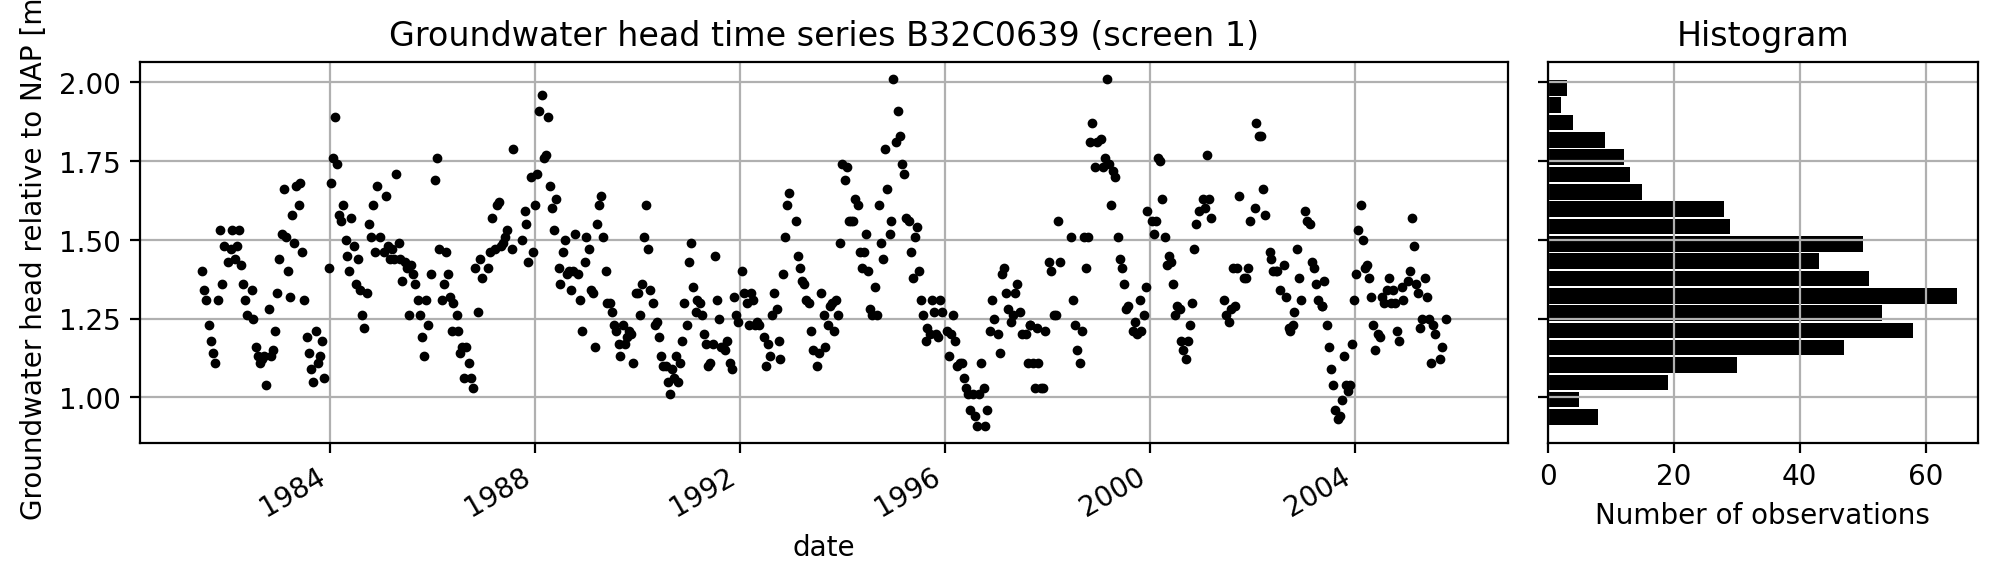

In [30]:
head_df = pd.read_csv("data/B32C0639001.csv", parse_dates=True, index_col="date")
head = head_df.iloc[:, 0]

fig = plt.figure(figsize=(10, 3))
gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1], sharey=ax1)


head.plot(ax=ax1, marker=".", color="k", linestyle=" ", markersize=5)
ax1.grid()
ax2.grid()
ax2.hist(head, orientation="horizontal", bins=20, color="k", rwidth=0.9)

ax1.set_title("Groundwater head time series B32C0639 (screen 1)")
ax1.set_ylabel("Groundwater head relative to NAP [m]")
ax2.set_title("Histogram")
ax2.set_xlabel("Number of observations")

plt.tight_layout()

### Precipitation and evaporation as separate influences

In this method, the two time series of precipitation and evaporation are included independently in the time series model. Using two separate response functions, the time series are translated into contributions to groundwater head fluctuations. 

Below is an example showing the result of such a model for the groundwater head time series measured in observation well B32C0639 (screen 1).


In [35]:
raw = pd.read_csv('data/etmgeg_260.txt', skiprows=47, index_col=1, parse_dates=True)


rain = pd.to_numeric(raw['   RH'], errors='coerce') / 10 
evap = pd.to_numeric(raw[' EV24'], errors='coerce') / 10

rain.name = "Precipitation"
evap.name = "Evaporation"

tmin = "1990"
tmax = "2001"

Columns (2,3,4,5,6,7,8,13,15,16,18,19,20,21,22,23,25,26,28,30,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.

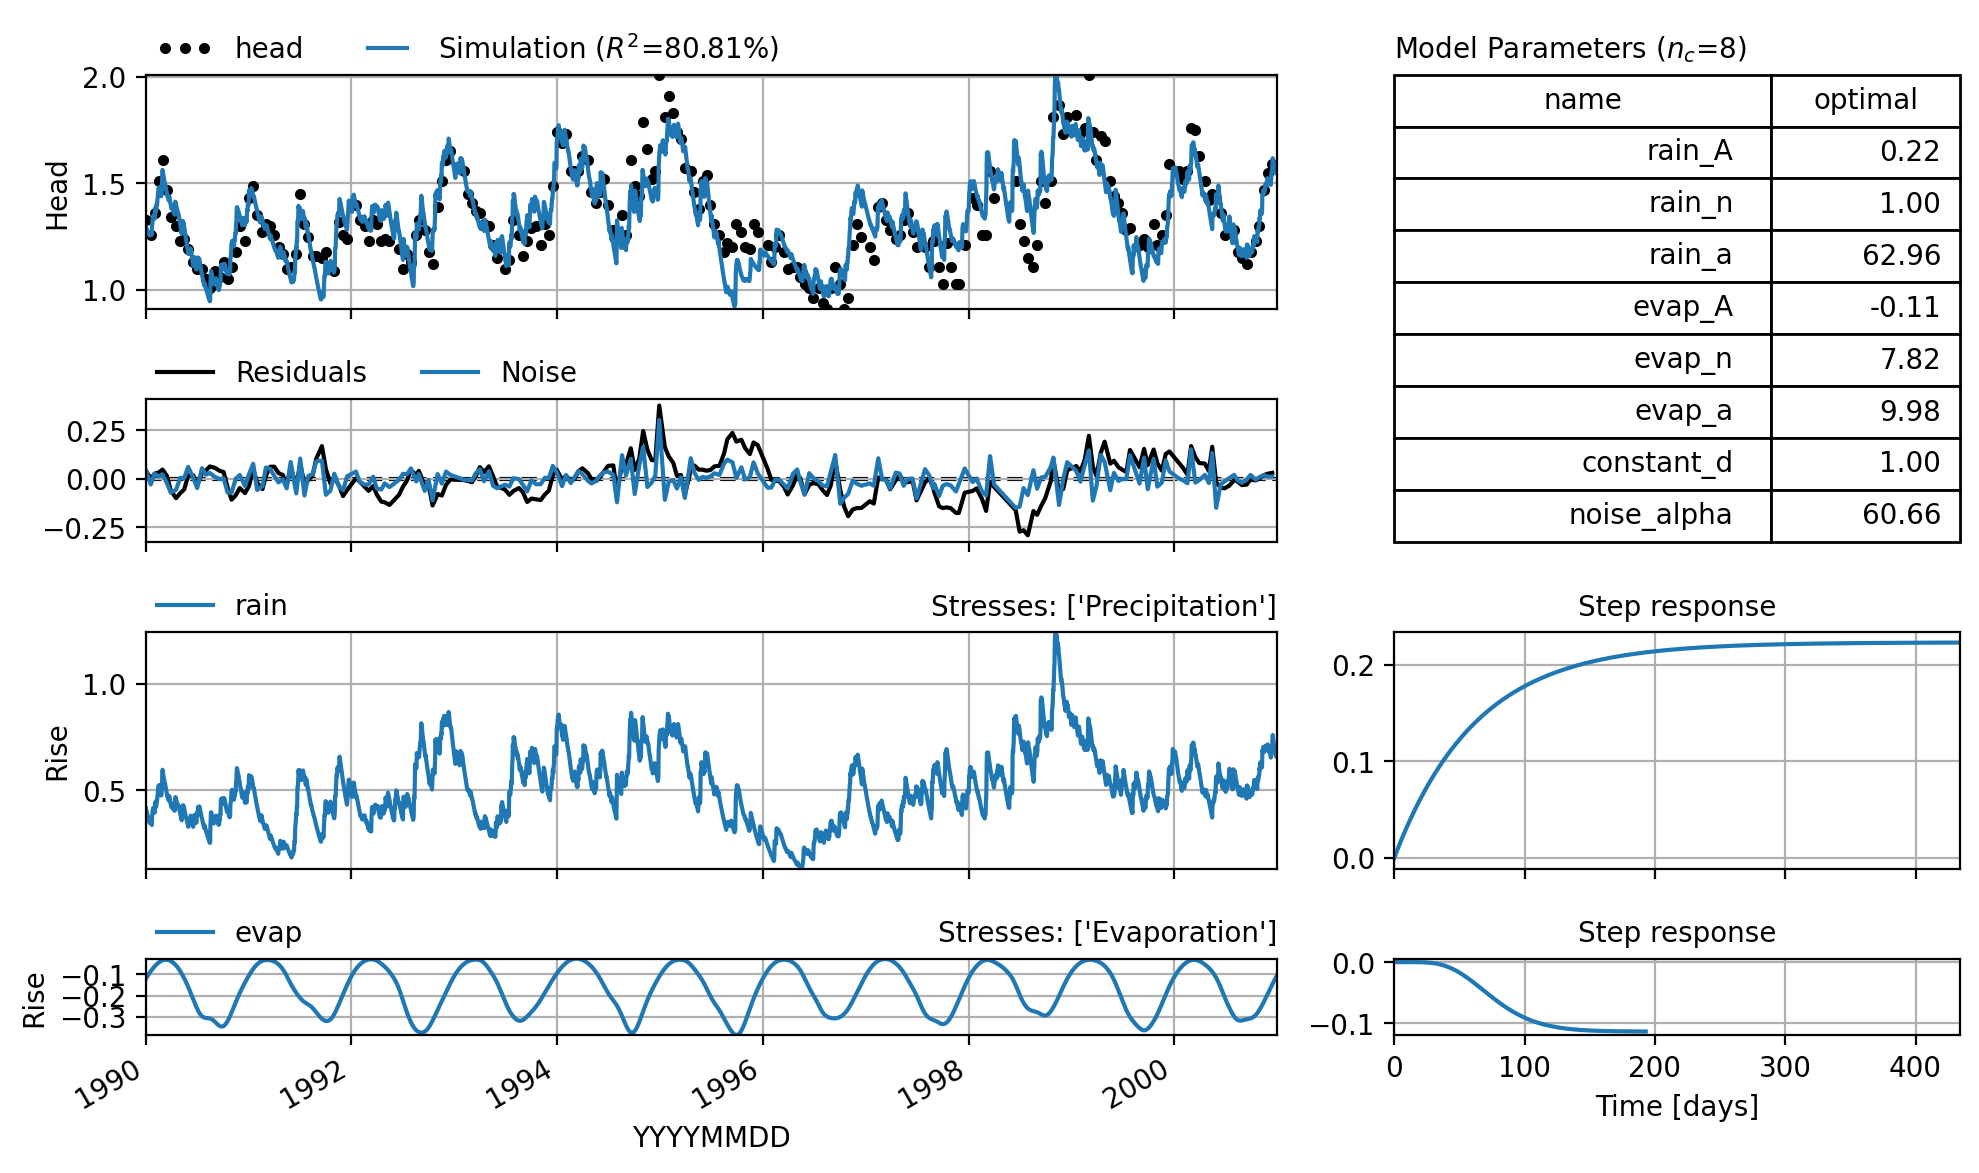

In [36]:
# Create the basic Pastas model
ml1 = ps.Model(head, name="2 responsen")

# Add a recharge model
rm1 = ps.StressModel(rain, rfunc=ps.Gamma(), name="rain", up=True, settings = 'prec')
rm2 = ps.StressModel(evap, rfunc=ps.Gamma(), name="evap", up=False, settings = 'prec')

ml1.add_stressmodel([rm1, rm2])

ml1.add_noisemodel(ps.ArNoiseModel())

# Solve the model
ml1.solve(tmin=tmin, tmax=tmax,
          report=False, fit_constant=fit_constant)
ml1.plots.results(figsize=(10, 6))
plt.tight_layout()

The bottom two left subplots show the estimated influence of precipitation and evaporation. Precipitation has a positive (increasing) effect on the groundwater head, while evaporation has a decreasing effect. For both response functions (see the bottom two right subplots), the parameters must be estimated. The total number of estimated parameters in this model is 8.

A few remarks regarding the physical interpretation of this model form are relevant. In this example, the groundwater head responses to precipitation and evaporation differ significantly. From a groundwater perspective, it is questionable whether it makes sense for these responses to differ so greatly. On the other hand, the response function is also responsible for representing processes in the unsaturated zone, and since the temporal patterns of precipitation and evaporation differ, it could make sense for the responses to differ as well.

### Linear Precipitation Surplus

A common assumption is that the groundwater head responds similarly to precipitation and evaporation, but in opposite directions (when it rains the groundwater head rises, when it evaporates the head falls). Although the figure above shows that this is not always the case, in practice this assumption often leads to good models. Under this assumption, the precipitation surplus can first be calculated and then translated into a contribution to head fluctuations using a single response function.

Because potential or reference evaporation (such as Makkink or Penman-Monteith) is often used, an evaporation factor $f$ is applied. The precipitation surplus $N$ is then calculated as [(see e.g. Berendrecht et al., 2003)](#References):

$$N(t) = P(t) - f * E(t)$$

where $P(t)$ is precipitation, $E(t)$ is potential evaporation, and $f$ is a calibration parameter. An important advantage of this model compared to the previous one is the smaller number of parameters that need to be estimated.


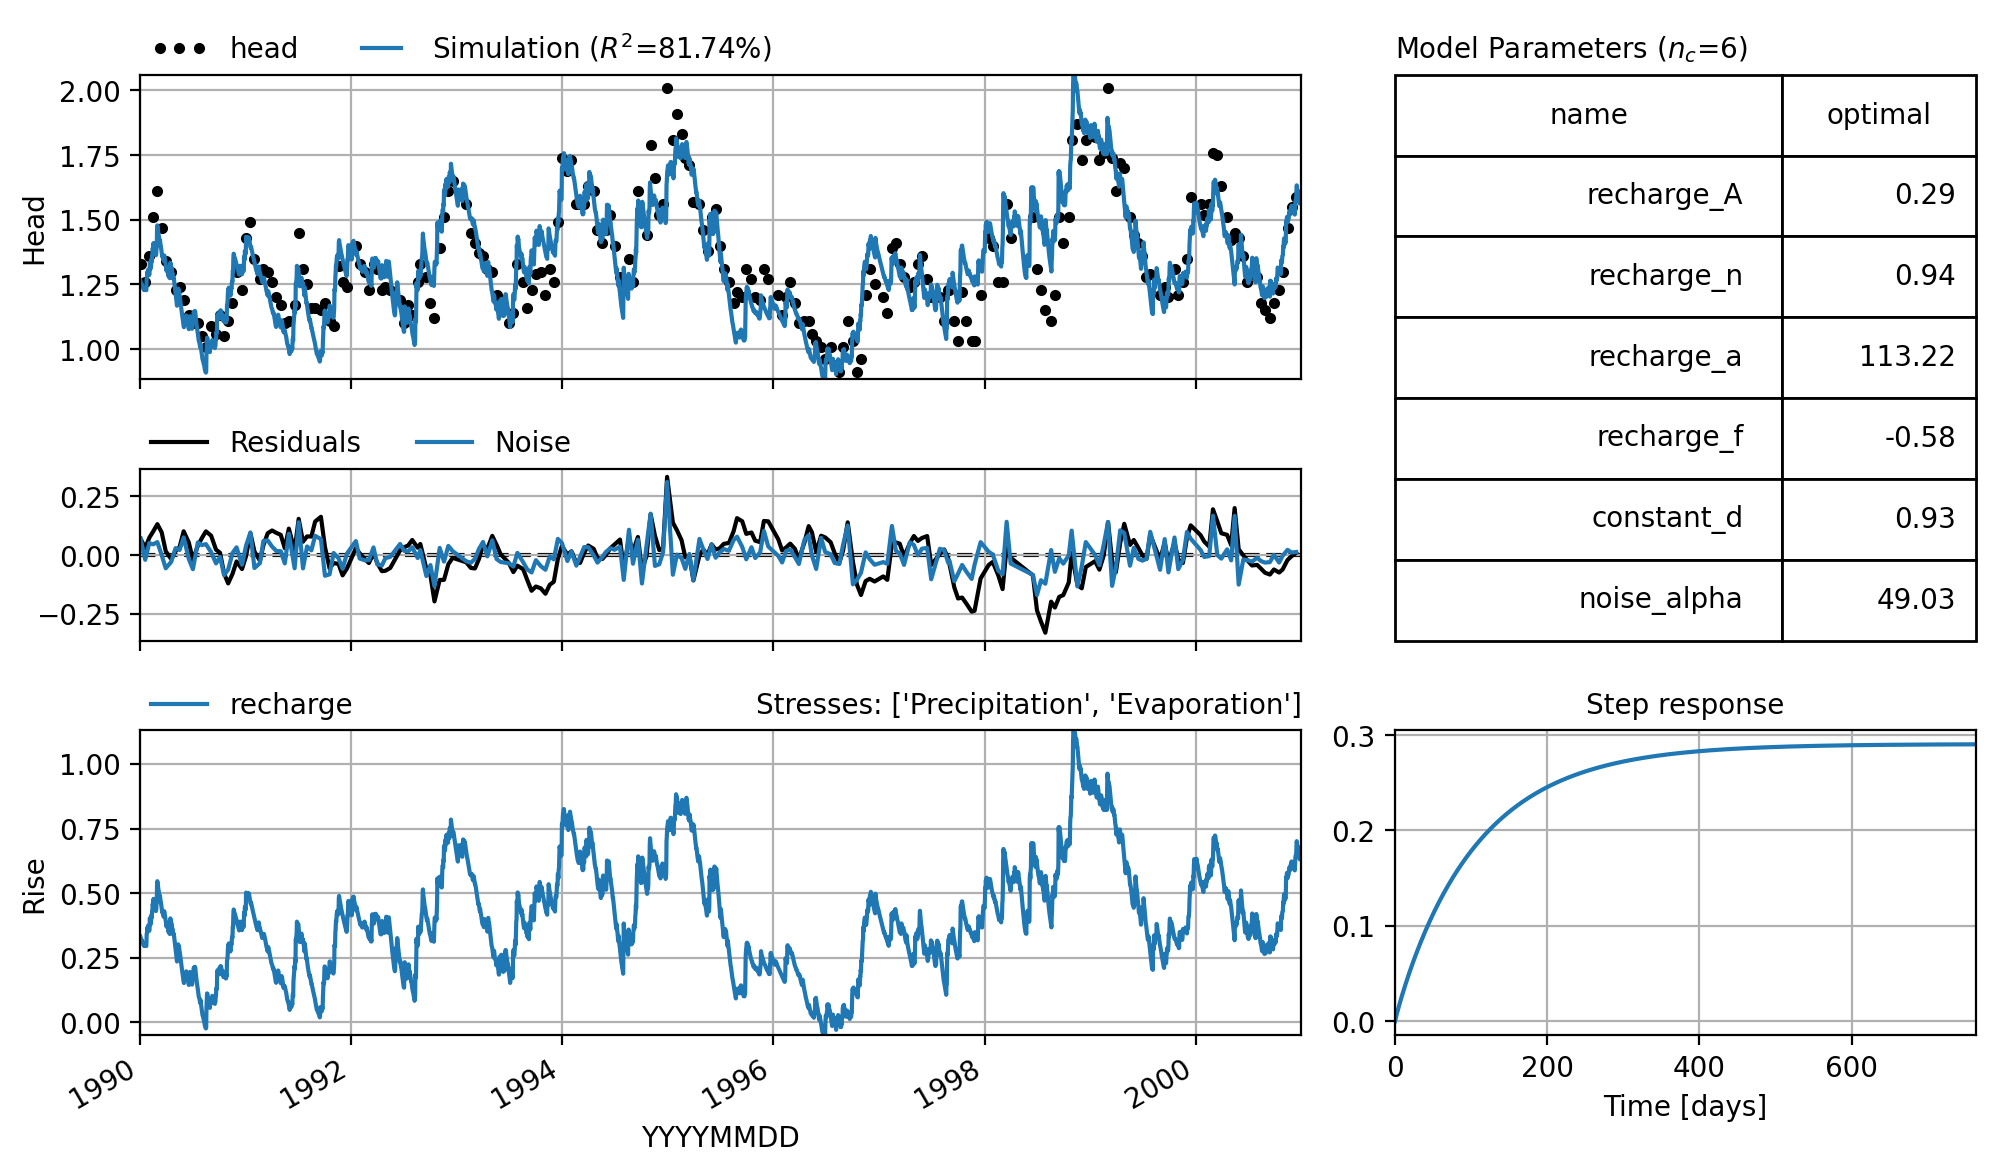

In [37]:
# Example of net precipitation surplus (N = P - fE) and gamma response function

# Create the basic Pastas model
ml2 = ps.Model(head, name="linear")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma(), name="recharge")
ml2.add_stressmodel(rm)
ml2.add_noisemodel(ps.ArNoiseModel())

# Solve the model
ml2.solve(tmin=tmin, tmax=tmax,
          report=False, fit_constant=fit_constant)
ml2.plots.results(figsize=(10, 6))
plt.tight_layout()

In the figure above, the result of this model for the example data is shown. The total number of estimated parameters in this model is 6. The estimated evaporation factor is $f = -0.59$, meaning that evaporation is 59% of the Makkink evaporation in this example. Although this model has two fewer calibration parameters, the model fit (measured as $R^2$) is nearly the same as that of the first model.

### Non-linear Groundwater Recharge

In the third method, a non-linear model is used to calculate the groundwater recharge. This flux is then translated into a contribution to groundwater head fluctuations using a response function. Several non-linear models are available — see for example [Berendrecht et al. (2005)](#References), [Peterson and Western (2014)](#References), and [Collenteur et al. (2020)](#References). All of these models follow the form of a "bucket", with precipitation ($P$) and evaporation ($E$) entering and exiting at the top, and groundwater recharge ($R$) coming out at the bottom.

To illustrate, the conceptual models from [Berendrecht et al. (2005)](#References) and [Collenteur et al. (2020)](#References) are shown below. For interpretation of the various model parameters in these non-linear models, refer to the mentioned publications.

![Non-linear groundwater recharge models](data/conceptual_models.png)

One advantage of non-linear models is that they account for (non-linear) processes in the root zone, meaning the groundwater head no longer responds linearly to precipitation and evaporation (i.e., twice as much rain does not result in twice the increase in head). This occurs, for example, when evaporation is limited by the available soil moisture during dry periods, or when extreme rainfall is temporarily stored in the root zone.

In the figure below, the result of this model is shown. The total number of estimated parameters in this model is 9, as 3 parameters were fixed based on expert knowledge.

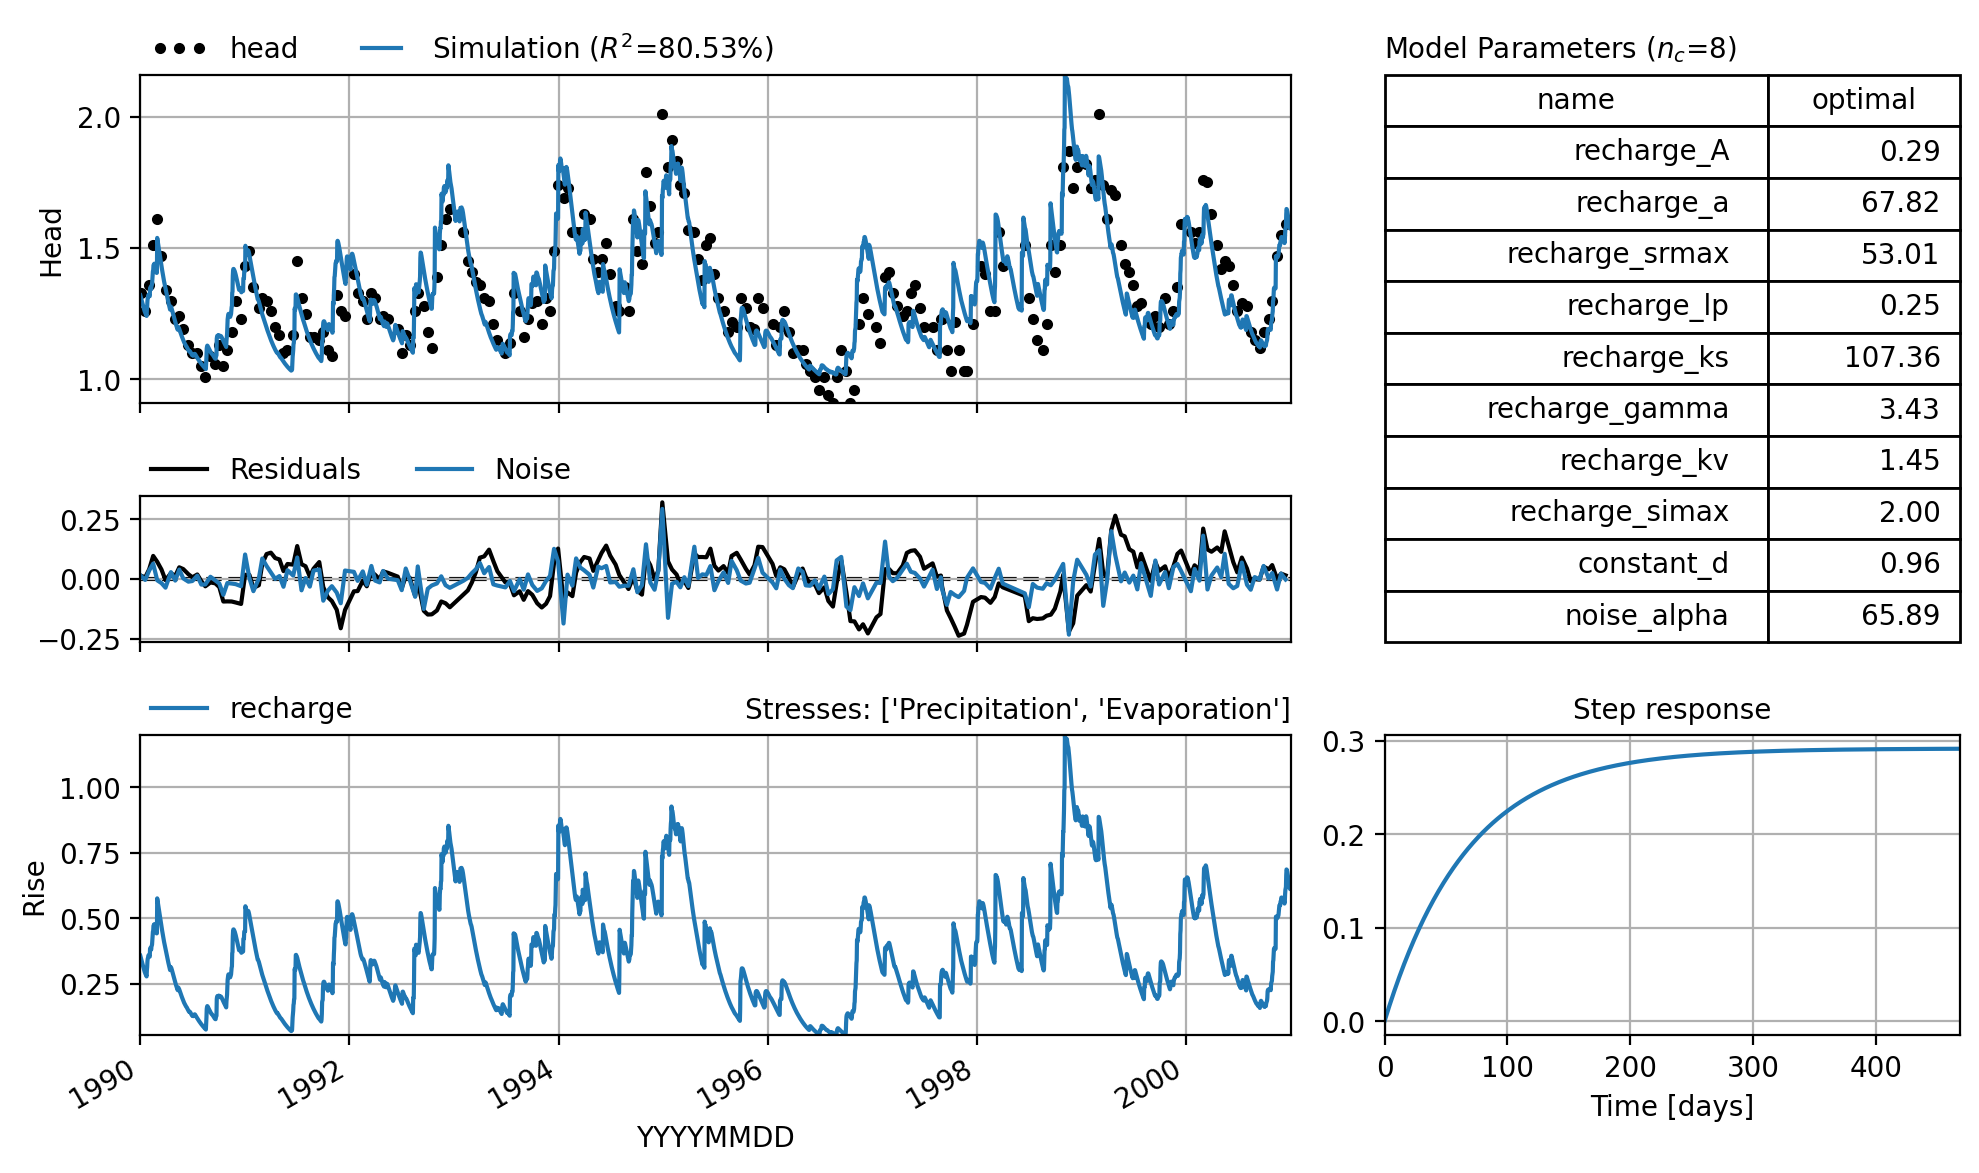

In [38]:
# Example of Non-linear Groundwater Recharge and Exponential Response Function

ml3 = ps.Model(head, name="non-linear")

# Add a recharge model
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Exponential(), name="recharge")
ml3.add_stressmodel(rm)
ml3.add_noisemodel(ps.ArNoiseModel())

# Solve the model
ml3.solve(tmin=tmin, tmax=tmax,
          report=False, fit_constant=fit_constant)
ml3.plots.results(figsize=(10, 6))
plt.tight_layout()

A possible disadvantage of non-linear models can be the larger number of free parameters. However, it is often possible to fix some parameters and use a response function with fewer parameters, thereby reducing the number of free parameters. The computation time of non-linear models is nowadays comparable to that of linear models.

### Which Model is Best?

We now have three models for a groundwater head time series that can be well explained by precipitation and potential evaporation. The model with two separate response functions has an $R^2 = 81.0\%$, the linear model $R^2 = 82\%$, and the non-linear model $R^2 = 81\%$, each for the period 1990–2001. So in terms of this fit statistic, the models do not differ greatly. It is now up to the modeler to choose one of these models — or to use all of them.

A commonly used method to select the "best" model is to assess the model performance outside the calibration period (see also the notebook on *Model Evaluation*). In the figure below, groundwater head is simulated for a period after the calibration period (2001–2006) using each model — the so-called validation period. The legend shows the Nash–Sutcliffe Efficiency (NSE) for each model. Now, the model with two response functions is the "best" model according to the NSE statistic (NSE = 0.86), while the linear and non-linear models have a slightly lower fit (NSE = 0.77).

The model fits are very similar in this example. In such a case, the modeler may, for instance, choose the model with the lowest number of parameters. That number is the lowest for the linear model ($n = 6$); the other two models both have more parameters ($n = 8$). The AIC statistic also clearly favors the linear model. Another motivation for model selection could depend on the purpose of the modeling. For example, if we are mainly interested in low groundwater levels, linear models seem more applicable, whereas high groundwater levels are better simulated with the non-linear model.

This clearly shows that the choice of a specific model depends on the objective of the modeling.


2 responsen, AIC=-1386.6
linear, AIC=-1365.52
non-linear, AIC=-1397.84


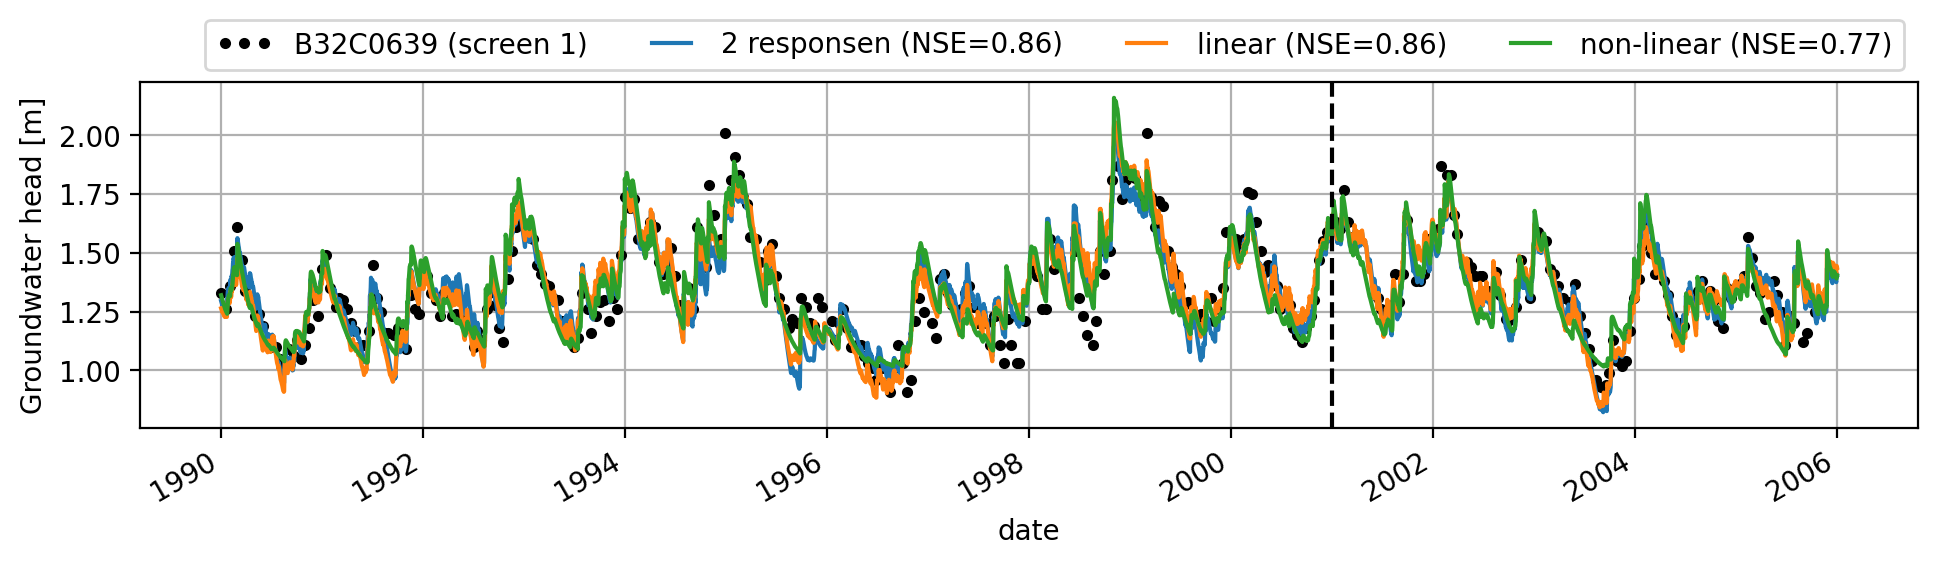

In [39]:
ax = ml1.oseries.series[tmin:].plot(
    marker=".", linestyle=" ", color="k", figsize=(10, 3))

labels = ["B32C0639 (screen 1)"] 

for ml in [ml1, ml2, ml3]:
    ml.simulate(tmax="2006").plot()
    labels.append("{} (NSE={})".format(
        ml.name, (ml.stats.nse(tmin=tmax, tmax="2006")).round(2)))
    print(f"{ml.name}, AIC={ml.stats.aic().round(2)}")

ax.axvline(pd.Timestamp(tmax), color="k", linestyle="--")
ax.grid()
plt.legend(labels, ncol=4, bbox_to_anchor=(1, 1.22), numpoints=3)
plt.ylabel("Groundwater head [m]")
plt.tight_layout()


### Thicker Unsaturated Zone

From the previous example, it became clear that a linear model for this well and groundwater head time series is better able to simulate low groundwater levels. In that case, the groundwater table was close to the land surface, meaning that the root zone (or rather, the vegetation) could take up water directly from the groundwater. The linear model can simulate a negative flux for the precipitation surplus, while the non-linear model used in the previous example cannot. [Peterson et al. (2014)](#References) developed a non-linear model for deep groundwater levels and deep root systems in Australia, where water can also be extracted from the groundwater and evaporated.

In the Netherlands, such deep root systems are less common, and in systems with thick unsaturated zones, soil water generally moves from the root zone to the groundwater. When there is no evaporation directly from the groundwater, a non-linear model may help to simulate groundwater head. Whether using a non-linear model improves the simulation of a groundwater head time series is a subject of research and must be evaluated for each well individually. Here too, the recommendation is to simply test this model type and experiment with it, just as with response functions.

#### Example: Well B27D0140

In the example below, a groundwater head time series has been modeled for a location with a thicker unsaturated zone. The time series was measured in well B27D0140 (screen 1) near Oldebroek, north of the Veluwe. In this example, the fit to the observations is improved by using a non-linear model to calculate the groundwater recharge.


In [67]:
head = pd.read_csv('data/B27D0140001_1.csv', skiprows=16, index_col=2, parse_dates=True).iloc[:, 4]/100
'''
prec_df = pd.read_csv(
    "data/neerslaggeg_OLDEBROEK_336.txt",
    skiprows=23, 
    usecols=["YYYYMMDD", "   RD"], 
)

prec_df["date"] = pd.to_datetime(prec_df["YYYYMMDD"], format="%Y%m%d")
prec_df.set_index("date", inplace=True)
prec_df["RD"] = pd.to_numeric(prec_df["   RD"], errors="coerce") * 1e3
prec = prec_df["RD"].asfreq("D")
prec.name = "Precipitation"'''

rain_raw = pd.read_csv('data/neerslaggeg_OLDEBROEK_336.txt', skiprows=23, index_col=0, parse_dates=True)
rain_raw.index = pd.to_datetime(rain_raw["YYYYMMDD"], format="%Y%m%d")
prec = rain_raw["   RD"].asfreq("D").replace('     ', np.nan).astype(float)
prec.name = "Precipitation"

evap_df = pd.read_csv(
    "data/etmgeg_275.txt",
    skiprows=47, 
    usecols=["YYYYMMDD", " EV24"],  
)

evap_df["date"] = pd.to_datetime(evap_df["YYYYMMDD"], format="%Y%m%d")
evap_df.set_index("date", inplace=True)
evap_df["EV24"] = pd.to_numeric(evap_df[" EV24"], errors="coerce") 
evap = evap_df["EV24"].asfreq("D")
evap.name = "Evaporation"

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.

In [74]:
ml = ps.Model(head, name="B27D0140_1")
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(prec, evap, recharge=rch,
                      rfunc=ps.Exponential(), name="rch")
ml.add_stressmodel(rm)

# Solve the model
ml.set_parameter("rch_kv", vary=True)  
ml.solve(tmin="2000", tmax="2015",
         report=False, fit_constant=fit_constant)
r2_nl = round(ml.stats.rsq(), 2)
sim = ml.simulate(tmax="2018")

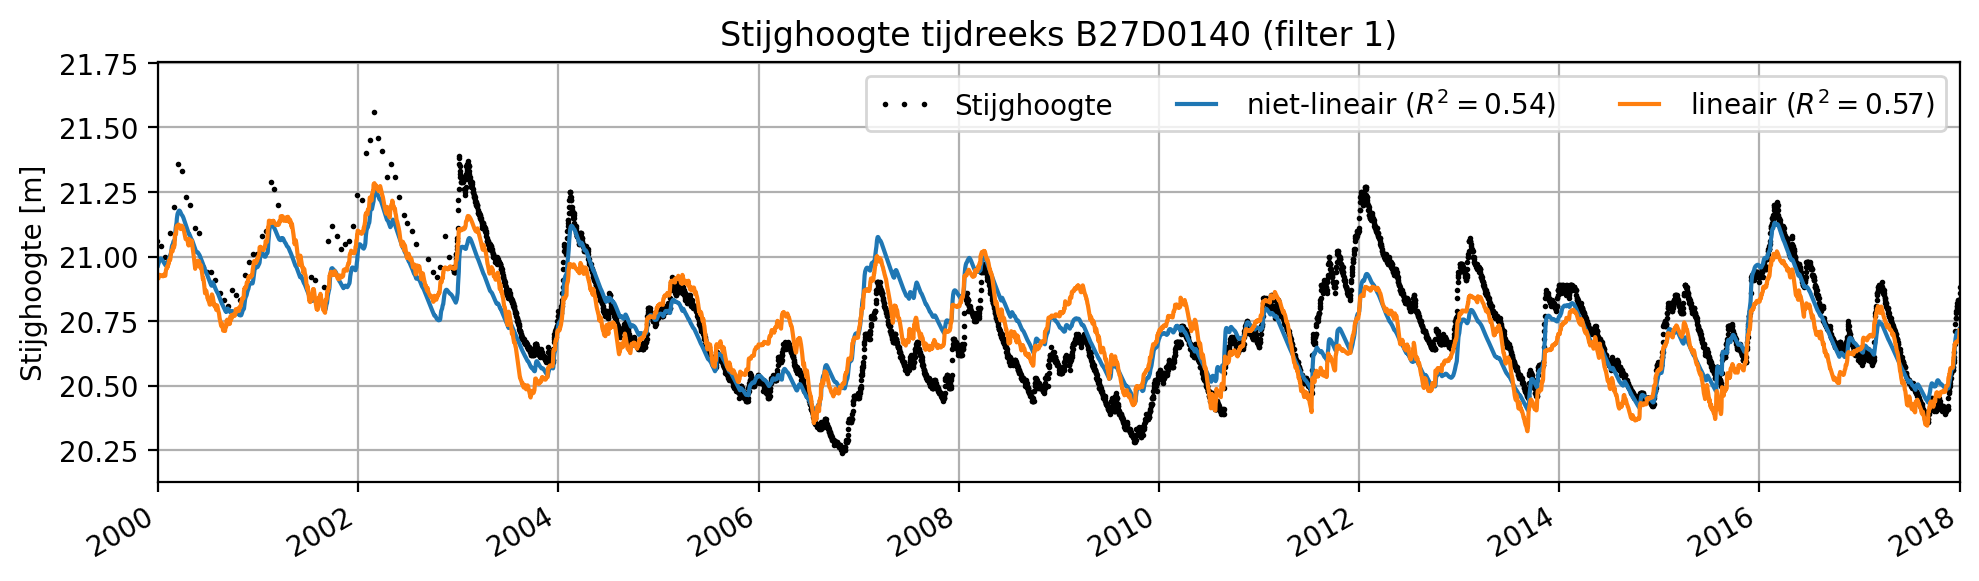

In [75]:
ml = ps.Model(head, name="B27D0140_1")
rch = ps.rch.Linear()
rm = ps.RechargeModel(prec, evap, recharge=rch,
                      rfunc=ps.Exponential(), name="rch")
ml.add_stressmodel(rm)
# Solve the model
ml.solve(tmin="2000", tmax="2015",
         report=False, fit_constant=fit_constant)
r2_l = round(ml.stats.rsq(), 2)

# Plot de resultaten
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
head.plot(ax=ax, marker=".", color="k", linestyle=" ", markersize=2)

ax.plot(sim)
ml.simulate(tmax="2018").plot(ax=ax)
ax.set_xlim(["2000", "2018"])
#ax.set_ylim(18.2, 20.0)
ax.set_ylabel("Stijghoogte [m]")
ax.set_title("Stijghoogte tijdreeks B27D0140 (filter 1)")
ax.grid()
ax.legend(["Stijghoogte",  f"niet-lineair ($R^2=${r2_nl})",
          f"lineair ($R^2=${r2_l})"], ncol=4, loc=1, numpoints=3)
plt.tight_layout()

## Threshold Non-Linearity

A common phenomenon in the Netherlands is threshold non-linearity (see e.g. [Berendrecht et al. (2004) and von Asmuth et al. (2012)](#References)). In such cases, a groundwater system responds differently to precipitation after a certain threshold in groundwater head has been exceeded. Among others, [Knotters et al. (1999)](#References) developed a model for this — the so-called TARSO model — in which the response to precipitation surplus depends on whether the groundwater head is above or below a specific threshold value.

For example, when the groundwater head rises above this threshold, runoff to surface water may occur (e.g., into a ditch that would otherwise be dry).

Whether threshold non-linearity is present can be investigated by:

- Visually inspecting the groundwater head time series.
- Plotting a histogram of groundwater head measurements.
- Testing different model structures.

#### Example: Well B28H1804

As an example, we look at the groundwater head time series measured in well B28H1804 (screen 1) near Weerselo. Data from Dinoloket indicate that the ground surface elevation at this point is 19.44 meters relative to NAP (Dutch Ordnance Datum). The figure below shows the groundwater head time series and a histogram of the series for visual inspection (steps 1 & 2).


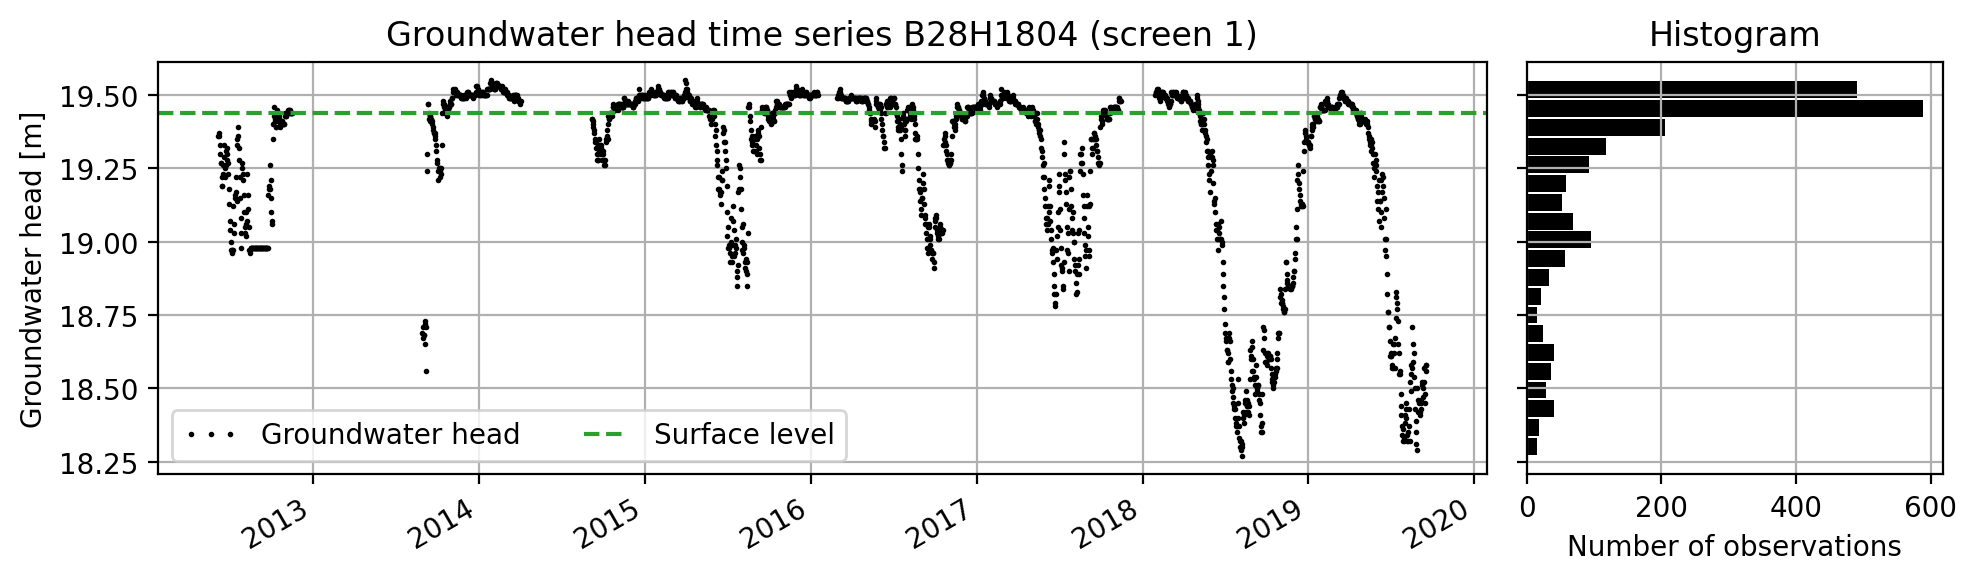

In [13]:
head = pd.read_csv('data/B28H1804001_1.csv', skiprows=16, index_col=2, parse_dates=True).iloc[:, 4]/100
head.index = pd.to_datetime(head.index, dayfirst=True)

fig = plt.figure(figsize=(10, 3))
gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1], sharey=ax1)

head.plot(ax=ax1, marker=".", color="k", linestyle=" ", markersize=2)
ax1.grid()
ax2.grid()

plt.hist(head, orientation="horizontal", bins=20, color="k", rwidth=0.9)

ax1.axhline(19.44, linestyle="--", color="C2")

ax1.set_title("Groundwater head time series B28H1804 (screen 1)")
ax1.set_ylabel("Groundwater head [m]")
ax2.set_title("Histogram")
ax2.set_xlabel("Number of observations")
ax1.legend(["Groundwater head", "Surface level"], ncol=2, numpoints=3)

plt.tight_layout()

From the plots above, it can be inferred that threshold non-linearity may be present. The groundwater head series shows flattening around 19.50–19.75 meters, and the histogram clearly displays a skewed distribution. Based on this visual inspection, we can decide to try two models: the first with a simple precipitation surplus ($N = P - fE$), and the second with threshold non-linearity (in this case, the TARSO model). We can then evaluate which model performs better.

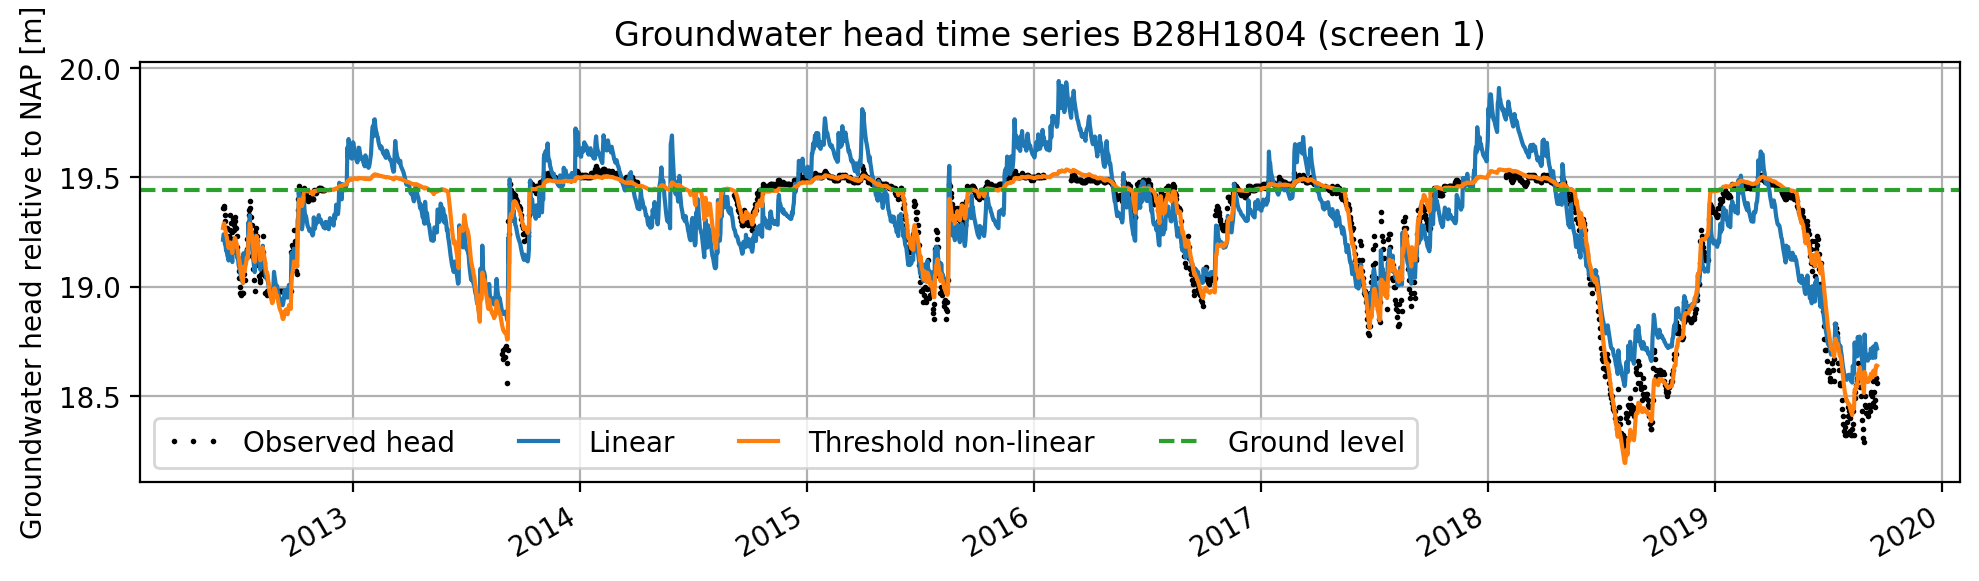

In [14]:
# Load precipitation and evaporation data
prec = pd.read_csv("data/RD Weerselo.csv", index_col=0, parse_dates=True).iloc[:, 0] * 1e3
evap = pd.read_csv("data/EV24 Twenthe.csv", index_col=0, parse_dates=True).iloc[:, 0] * 1e3

# Create the Pastas model
ml = ps.Model(head, name="B28H1804_1")

# Add a standard linear recharge model with Gamma response function
rm = ps.RechargeModel(prec, evap, name="recharge",
                      rfunc=ps.Gamma(), recharge=ps.rch.Linear())
ml.add_stressmodel(rm)

# Solve the model
ml.solve(report=False, fit_constant=fit_constant)
sim = ml.simulate()

# Delete all stressmodels, the constant, and transformation
ml.del_stressmodel('recharge')
ml.del_constant()

# Add the Tarso (threshold non-linear) model
sm = ps.TarsoModel(prec, evap, ml.oseries.series)
ml.add_stressmodel(sm)

# Solve again with the new model
ml.solve(report=False)

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
head.plot(ax=ax, marker=".", color="k", linestyle=" ", markersize=2)

ax.plot(sim)  # linear model result
ml.simulate().plot(ax=ax)  # Tarso model result

ax.set_ylabel("Groundwater head relative to NAP [m]")
ax.set_title("Groundwater head time series B28H1804 (screen 1)")
ax.axhline(19.44, linestyle="--", color="C2")  # ground level
ax.grid()

ax.legend(["Observed head", "Linear", "Threshold non-linear", "Ground level"],
          ncol=4, loc=3, numpoints=3)
plt.tight_layout()

The figure above shows the results of the two models. The linear model systematically overestimates the high groundwater heads, whereas the model with threshold non-linearity closely follows the observed groundwater levels. In this case, the observed hydrological behavior is better simulated with the non-linear threshold model. The TARSO model also makes it possible to display the outflow terms.

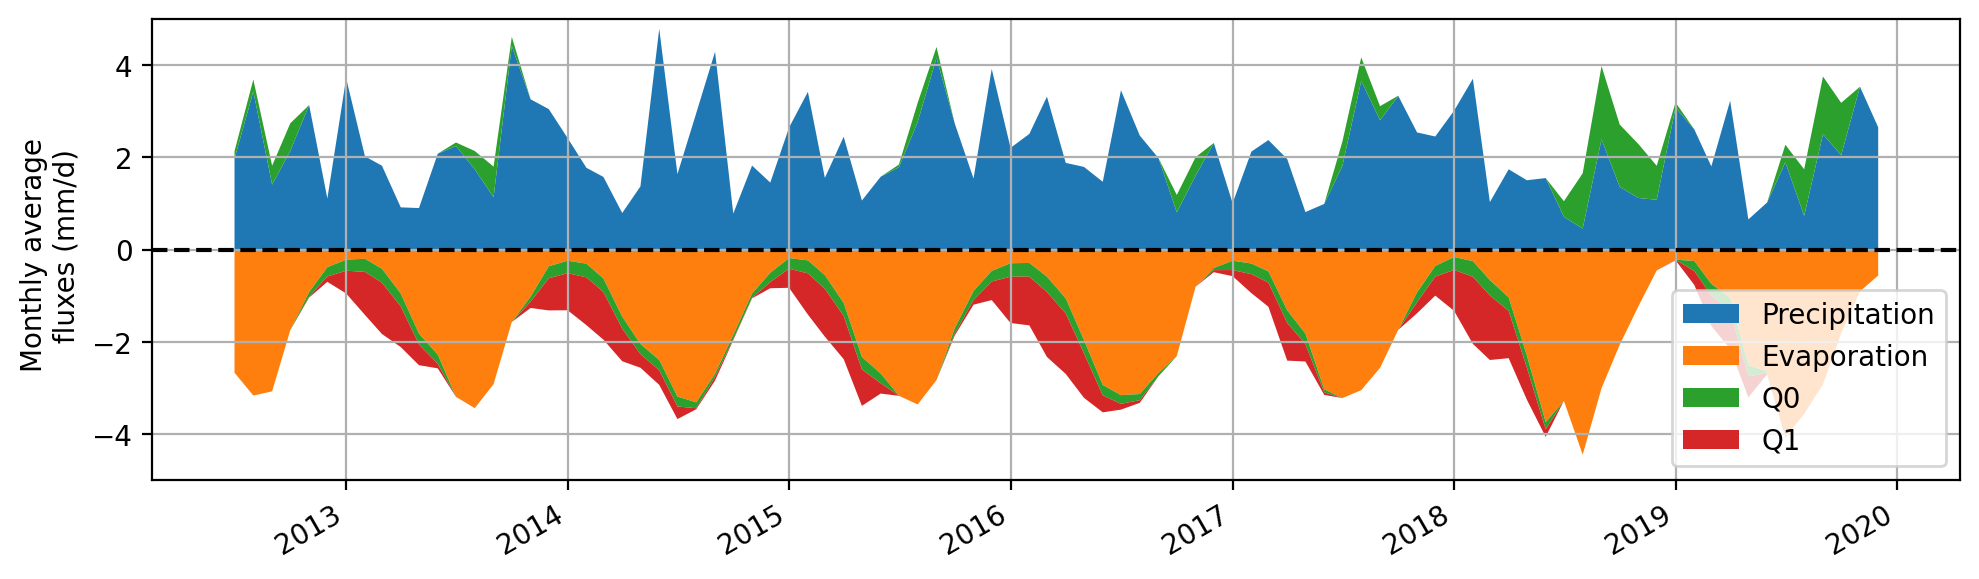

In [15]:
# Calculate the water balance
sim = ml.simulate()
P = prec.loc[sim.index.min():]  # Precipitation
E = -evap.loc[sim.index.min():]  # Evaporation
p = ml.get_parameters('recharge')
Q0 = -(sim - p[2]) / p[0]  # Outflow term Q0
Q1 = -(sim - p[5]) / p[3]  # Outflow term Q1
Q1[sim < p[5]] = 0.0  # Set Q1 to 0 when simulation is below threshold

# Combine these Series into a DataFrame
df = pd.DataFrame({'Precipitation': P, 'Evaporation': E, 'Q0': Q0, 'Q1': Q1})

# Resample the balance to monthly values for better readability in the graph
df = df.resample('ME').mean()

# Create a new figure
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Plot discharges in the lower graph
ax.set_ylabel('Monthly average \n fluxes (mm/d)')
color = ['C0', 'C1', 'C2', 'C3', 'C4']
df_up = df.where(df > 0, np.NaN)  # Positive values (fluxes)
df_down = df.where(df < 0, np.NaN)  # Negative values (fluxes)
df_up.plot.area(ax=ax, x_compat=True, color=color, linewidth=0, stacked=True)
df_down.plot.area(ax=ax, x_compat=True, color=color, linewidth=0, legend=False, stacked=True)

ax.axhline(0.0, linestyle='--', color='k')  # Zero line
plt.ylim(-5, 5)  # Limit the y-axis range
ax.grid(True)

# Finalize the plot layout
plt.tight_layout()

## Other Explanatory Variables

Up to this point, we have looked at groundwater head time series that can be well explained by precipitation and evaporation. However, in many cases, other explanatory time series are needed to accurately model groundwater head. Two influences that are often important are surface water levels and groundwater abstractions. The following two sections describe how the effects of these influences can be modeled.

### Surface Water Level as an Explanatory Time Series

In large parts of the Netherlands, groundwater heads are influenced by surface water levels. These can include major rivers and lakes such as the Rhine and IJsselmeer, but also smaller ponds and ditches in the polder landscape. It is not uncommon for a time series of a nearby surface water level to be added to the time series model in order to properly model the groundwater head.

Again, we can do this by translating the surface water level time series into a contribution to groundwater head fluctuations using a response function. The response function in this case describes how groundwater head reacts to fluctuations in the surface water level.

#### Example: Well 40CP0393

As an example, we model the groundwater head time series measured in well 40CP0393 (screen 4). First, we create a model using only precipitation and evaporation as explanatory variables. These are translated into groundwater head fluctuations using a linear precipitation surplus model and a Gamma response function. This model results in the following simulation of the groundwater head.

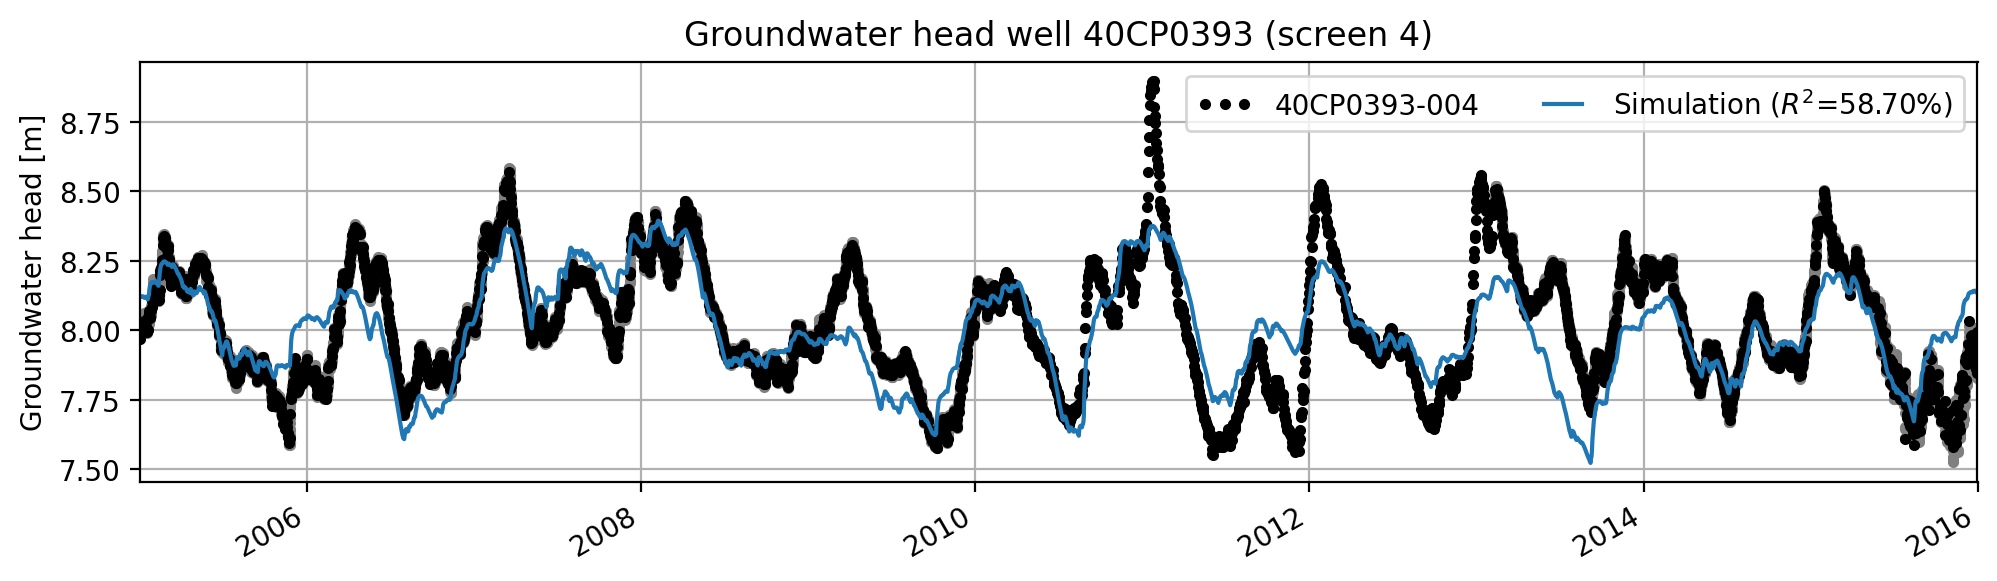

In [16]:
head = pd.read_csv("data/40CP0393-004.csv", index_col=0, parse_dates=True).iloc[:, 0]
prec = pd.read_csv("data/RD_Nijmegen.csv", index_col=0, parse_dates=True).iloc[:, 0] * 1e3
evap = pd.read_csv("data/EV24_Deelen.csv", index_col=0, parse_dates=True).iloc[:, 0] * 1e3

# Create the model
ml = ps.Model(head, name="40CP0393 (screen 4)")

# Add an autoregressive noise model
ml.add_noisemodel(ps.ArNoiseModel())

# Add the recharge model with Gamma response
sm = ps.RechargeModel(prec, evap, name="rch",
                      recharge=ps.rch.Linear(), rfunc=ps.Gamma())
ml.add_stressmodel(sm)

# Solve the model between 2005 and 2016
ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=fit_constant)

# Plot the results
ax = ml.plot(figsize=(10, 3))
ax.set_title("Groundwater head well 40CP0393 (screen 4)")
ax.set_ylabel("Groundwater head [m]")
ax.grid()
plt.tight_layout()

The figure above clearly shows that the precipitation surplus alone is not sufficient to explain the groundwater head fluctuations. From the hydrological system analysis of the study area, it was found that the well is located near a river. We therefore add the river water level as an explanatory time series to the model and check whether this improves the simulation of the groundwater head. 

For this, we choose the Gamma response function with three parameters to translate surface water levels into groundwater head fluctuations. This response function is often a good starting point for representing the influence of surface water levels.

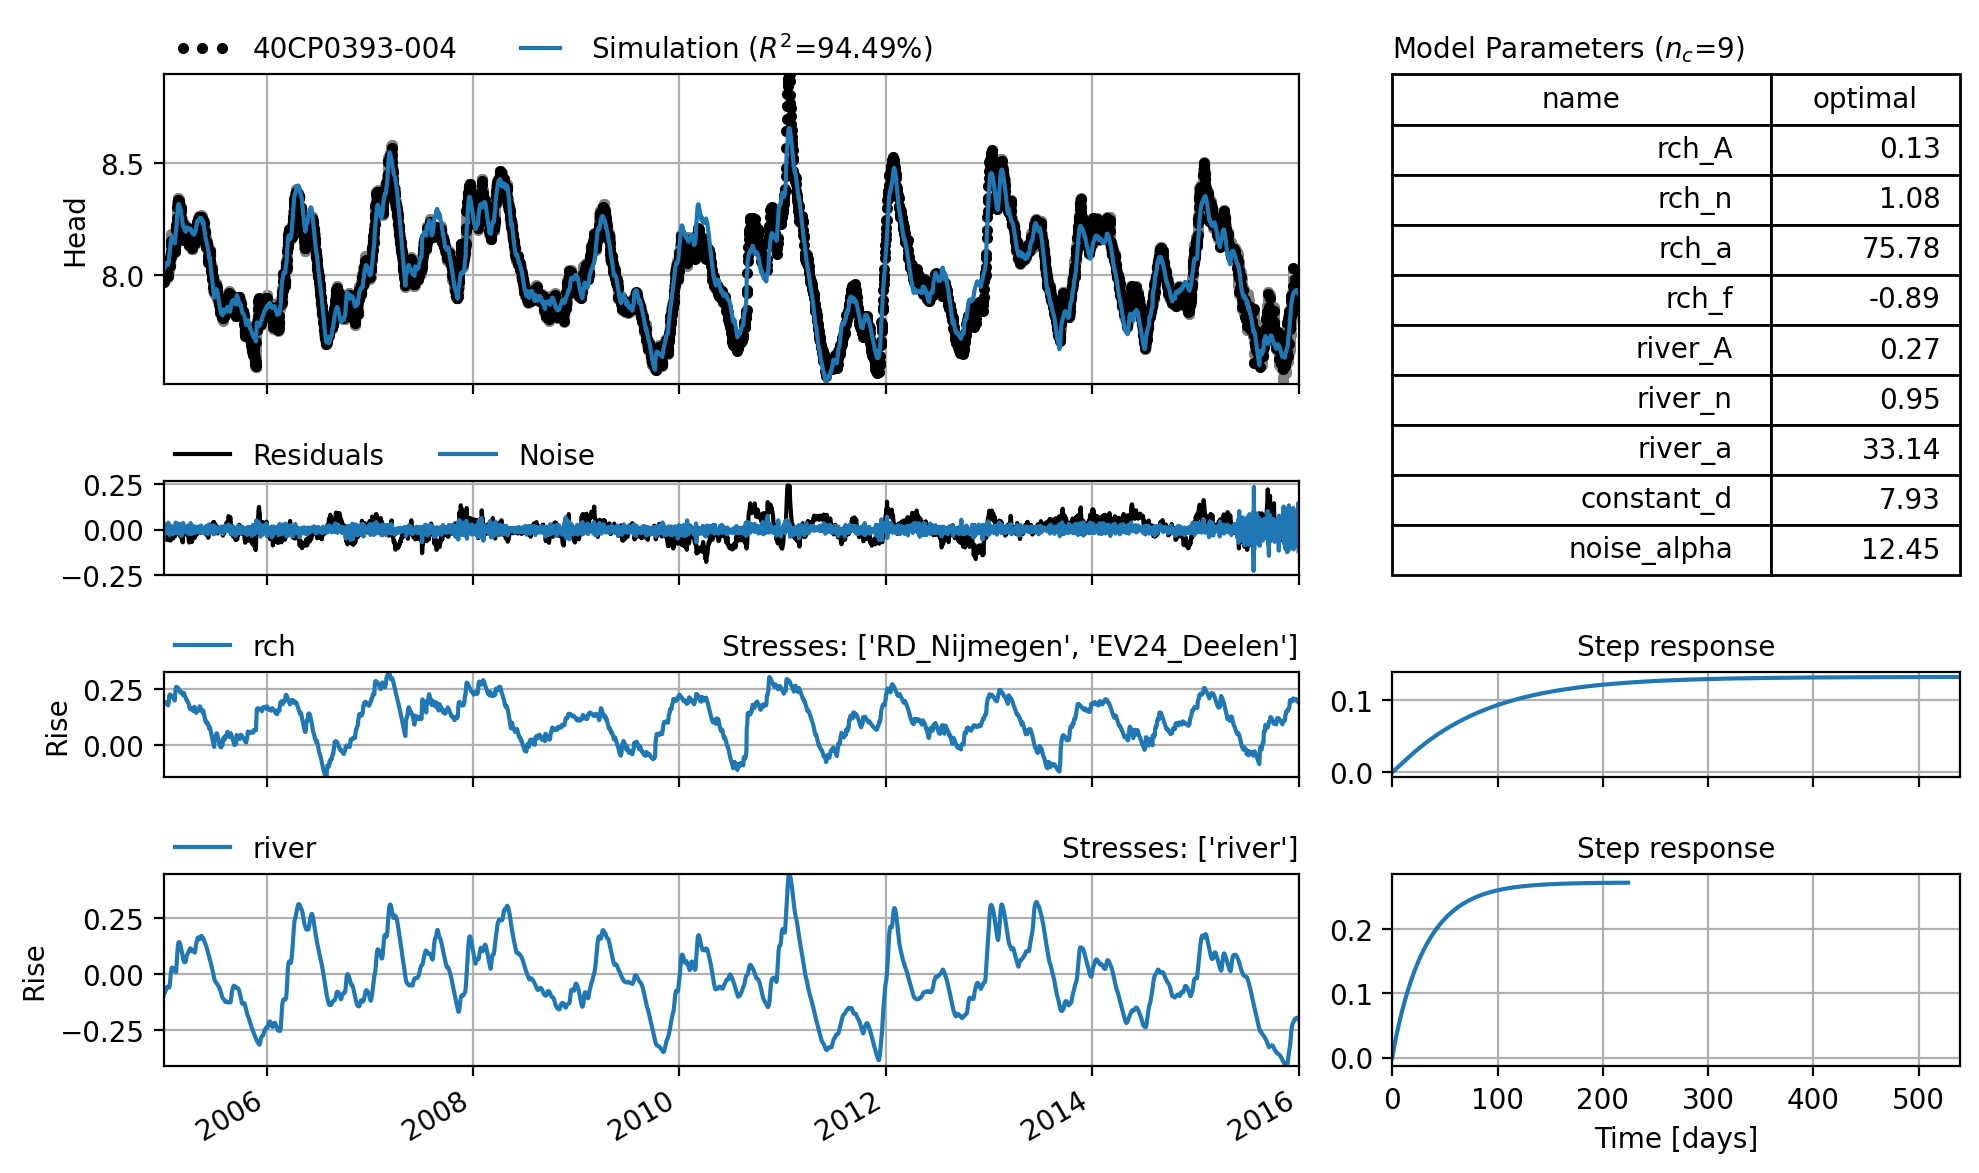

In [17]:
river = pd.read_csv("data/40CP0393-rivier.csv", index_col=0, parse_dates=True).iloc[:, 0]
sm2 = ps.StressModel(river, name="river", rfunc=ps.Gamma())
ml.add_stressmodel(sm2)
ml.add_stressmodel(sm)

ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=fit_constant)
ml.plots.results(figsize=(10, 6), adjust_height=True)
plt.tight_layout()

The model shows a clear improvement in the fit between the simulated and measured groundwater head. The fit, expressed here as $R^2$, increased from $R^2 = 59\%$ to $R^2 = 94.2\%$. Adding the surface water level thus clearly improves the model.

The calibrated response function for the effect of the river closely resembles an exponential response function, as can be seen from the block response and the value of the `rivier_n` parameter, which is nearly 1. This indicates that the groundwater head responds almost instantaneously to the river water level. When this is the case, it is recommended to replace the Gamma response function with the exponential response function. This saves one calibration parameter and produces the same model behavior. 

When the model fit is equal, a model with fewer parameters is preferred over a model with more. The figure below shows the model where the exponential response function is used instead of the Gamma function. The result demonstrates that it produces a comparable model, but with one less parameter.

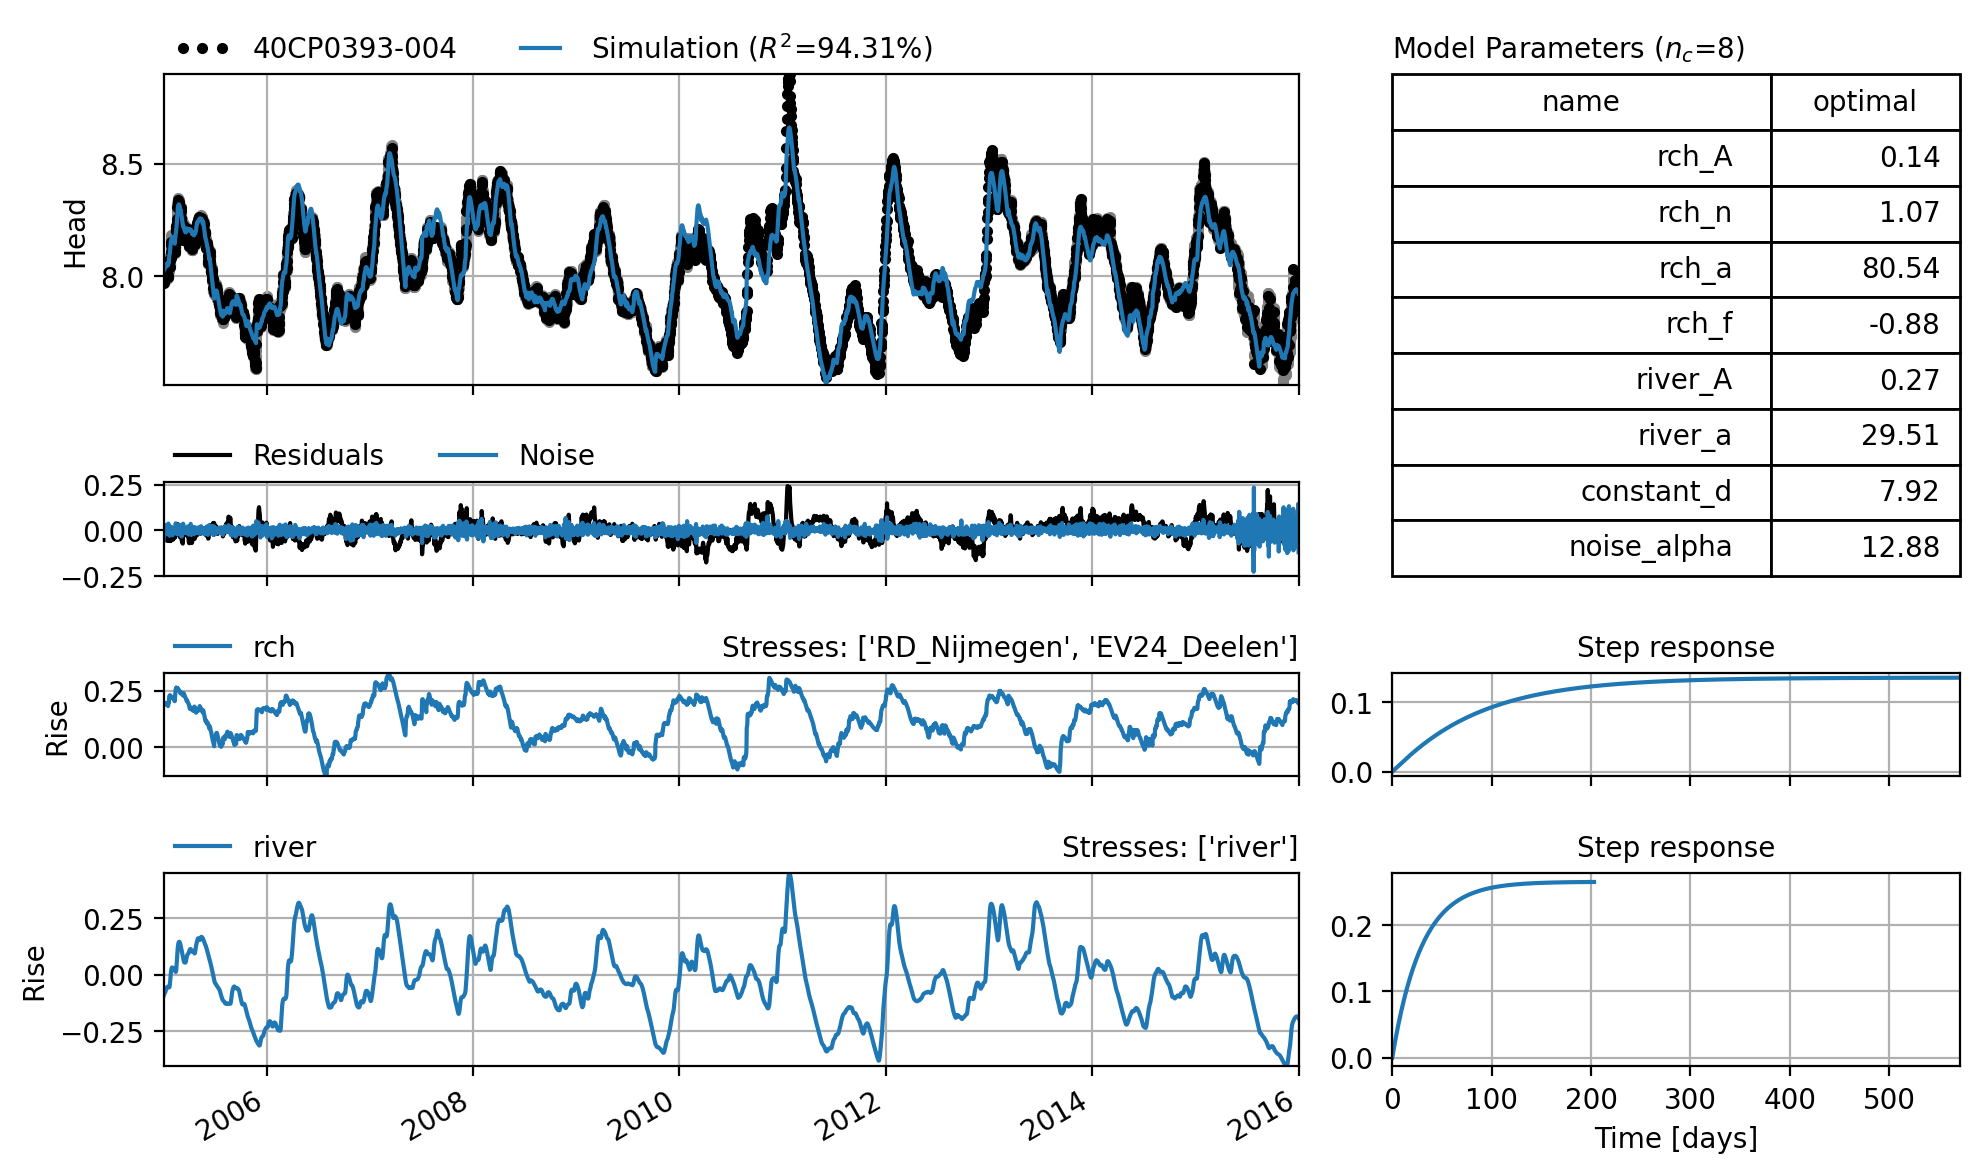

In [18]:
ml.del_stressmodel("river")
sm2 = ps.StressModel(river, name="river", rfunc=ps.Exponential())
ml.add_stressmodel(sm2)

ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=fit_constant)
ml.plots.results(figsize=(10, 6), adjust_height=True)
plt.tight_layout()

Both groundwater recharge and surface water levels are influenced by precipitation (when it rains heavily, river levels are often high as well). This can result in the parameters of these model components being strongly correlated, making it difficult to distinguish their individual contributions to groundwater head fluctuations.

In the previous model, this is already visually apparent; the correlation between the two contributions is $r = 0.43$. The stronger the correlation between these two contributions, the more difficult it becomes to attribute part of the groundwater head fluctuation to one of these influences. This may limit the ability to make precise statements about the effect of a specific influence on groundwater head.

In [19]:
contribution_river = ml.get_contribution("river")
contribution_recharge = ml.get_contribution("rch")

print(
    f"Correlation (r) between the contributions of the river and groundwater recharge: r={contribution_recharge.corr(contribution_river).round(2)}")


Correlation (r) between the contributions of the river and groundwater recharge: r=0.43


### Determining the Influence of a Groundwater Abstraction

Groundwater is used throughout almost all of the Netherlands for drinking water production and as a source of irrigation water. When modeling groundwater head time series in areas where groundwater is (or has been) abstracted, it is often necessary to include a time series of this abstraction in the model.

Some preprocessing of these time series is usually required, for example, to convert monthly volume totals into a time series with a consistent time step (e.g., daily totals). It can also be helpful to express the abstraction volumes in millions of cubic meters per time step, to avoid the simulation of extremely small parameter values. More details on this preprocessing and calibration can be found in the notebooks on "Preprocessing" and "Model Calibration".

#### Example: Well B46D0805 with Precipitation and Evaporation

As an example, we look at well B46D0805 (screen 1), located near a groundwater pumping station in Vierlingsbeek. Based on the hydrological system analysis, it is expected that precipitation, evaporation, and possibly groundwater abstraction should be included as explanatory variables in the model. 

Here, we start with a simple model based only on precipitation and evaporation. If this is sufficient to model the groundwater head time series, no further steps are needed. If not, we will add the abstraction time series from the pumping station as an additional explanatory variable.

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.Columns (2,3,4,5,6,7,8,13,15,16,18,19,20,21,22,23,25,26,28,30,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.

YYYYMMDD
1919-07-11    105000.0
1919-07-12         0.0
1919-07-13     34000.0
1919-07-14     56000.0
1919-07-15     64000.0
                ...   
2020-10-27     23000.0
2020-10-28     21000.0
2020-10-29     46000.0
2020-10-30     70000.0
2020-10-31      1000.0
Name: Precipitation, Length: 37004, dtype: float64

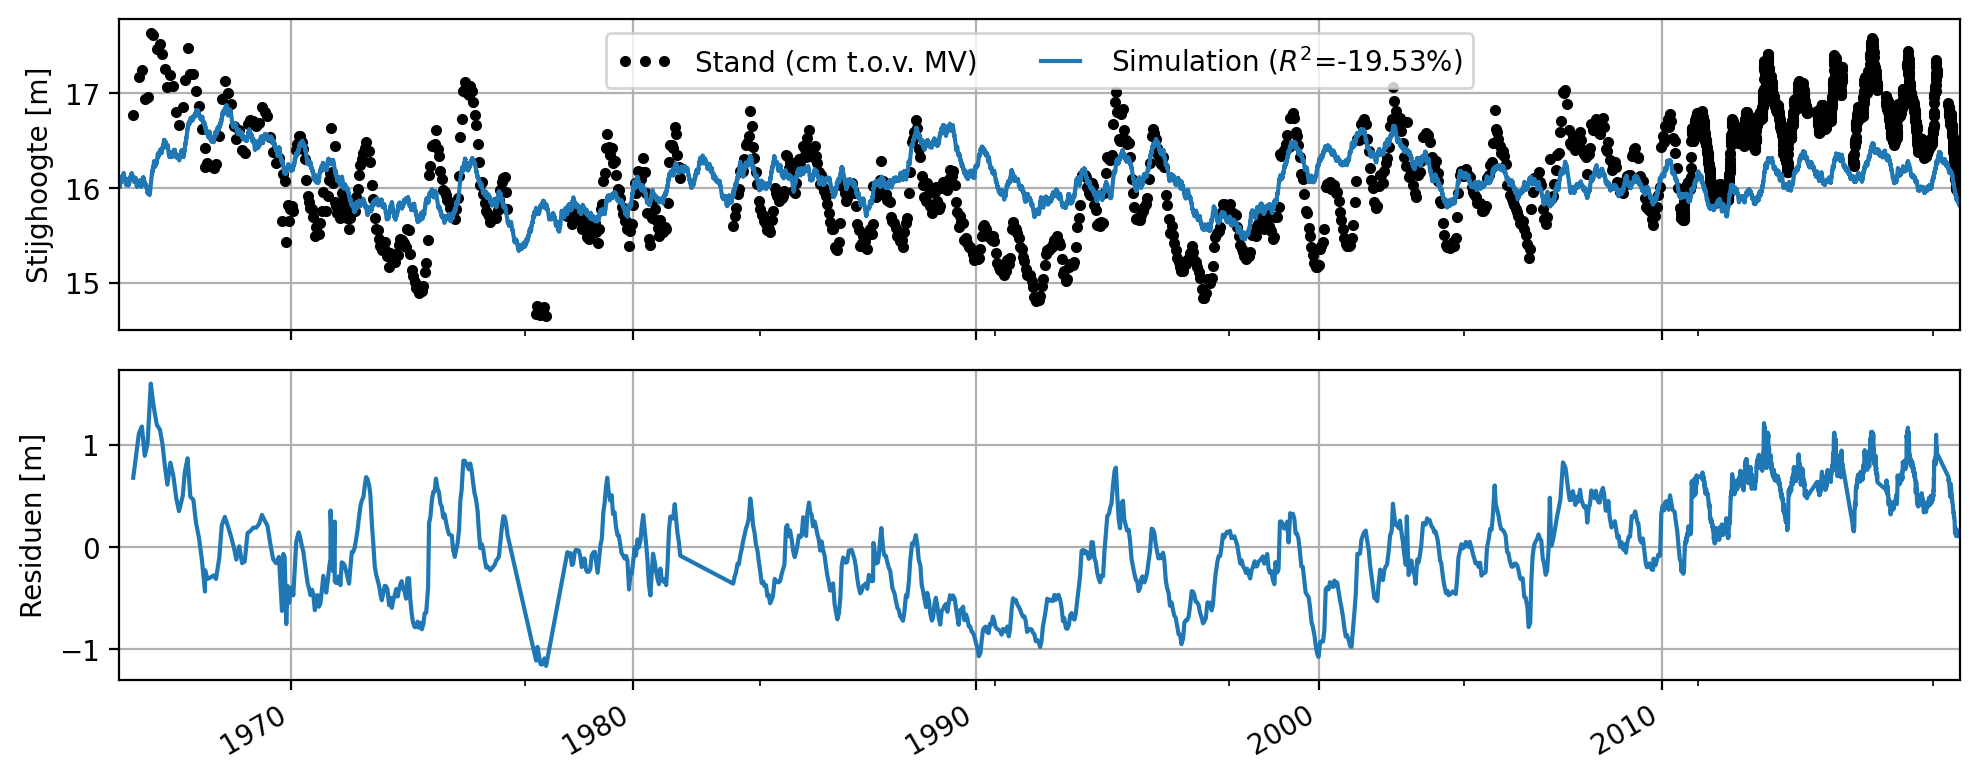

In [76]:
head = pd.read_csv('data/B46D0805001_1.csv', skiprows=15, index_col=2, parse_dates=True).iloc[:, 4]/100

rain = (
    pd.read_csv("data/precipitation_st_anthonis.txt", skiprows=23)
    .assign(YYYYMMDD=lambda df: pd.to_datetime(df["YYYYMMDD"], format="%Y%m%d"))
    .set_index("YYYYMMDD")["   RD"].pipe(pd.to_numeric, errors='coerce')*1e3
)
rain.name = "Precipitation"


raw = pd.read_csv('data/etmgeg_260.txt', skiprows=47, index_col=1, parse_dates=True)
evap = pd.to_numeric(raw[' EV24'], errors='coerce') * 1e3
evap.name = "Evaporation"

well = pd.read_csv("data/abstraction_vierlingsbeek_daily.csv", index_col="Date",
                   parse_dates=True).iloc[:, 0]* 365.25 / 1e6



ml = ps.Model(head)
sm = ps.RechargeModel(rain, evap, name="rch",
                      rfunc=ps.Exponential(), recharge=ps.rch.FlexModel())
ml.add_stressmodel(sm)
ml.solve(initial=True, report=False,
         tmin="1965", fit_constant=fit_constant)
ml.set_parameter("rch_srmax", vary=False)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(initial=False, report=False,
         tmin="1965", fit_constant=fit_constant)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ml.plot(ax=ax1)
ml.residuals().plot(ax=ax2)
ax1.grid()
ax2.grid()
ax1.set_ylabel("Stijghoogte [m]")
ax2.set_ylabel("Residuen [m]")
plt.tight_layout()

# print((ml.stats.nse(weighted=True).round(2)**2).round(2))  # Want ongelijke tijdstappen
rain

The figure above shows the observed and simulated groundwater head time series in the top plot, and the model residuals in the bottom plot. A clear trend can be seen in the residuals over time, which suggests that an influence might be missing from the model. 

We therefore add the time series of the abstraction discharge to the model. This series is translated into a contribution to the groundwater head fluctuations using a Gamma response function. This results in the following model.

[<Axes: ylabel='Head'>,
 <Axes: >,
 <Axes: title={'right': "Stresses: ['Precipitation', 'Evaporation']"}, xlabel='YYYYMMDD', ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'right': "Stresses: [' Discharge']"}, ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=10)'}>]

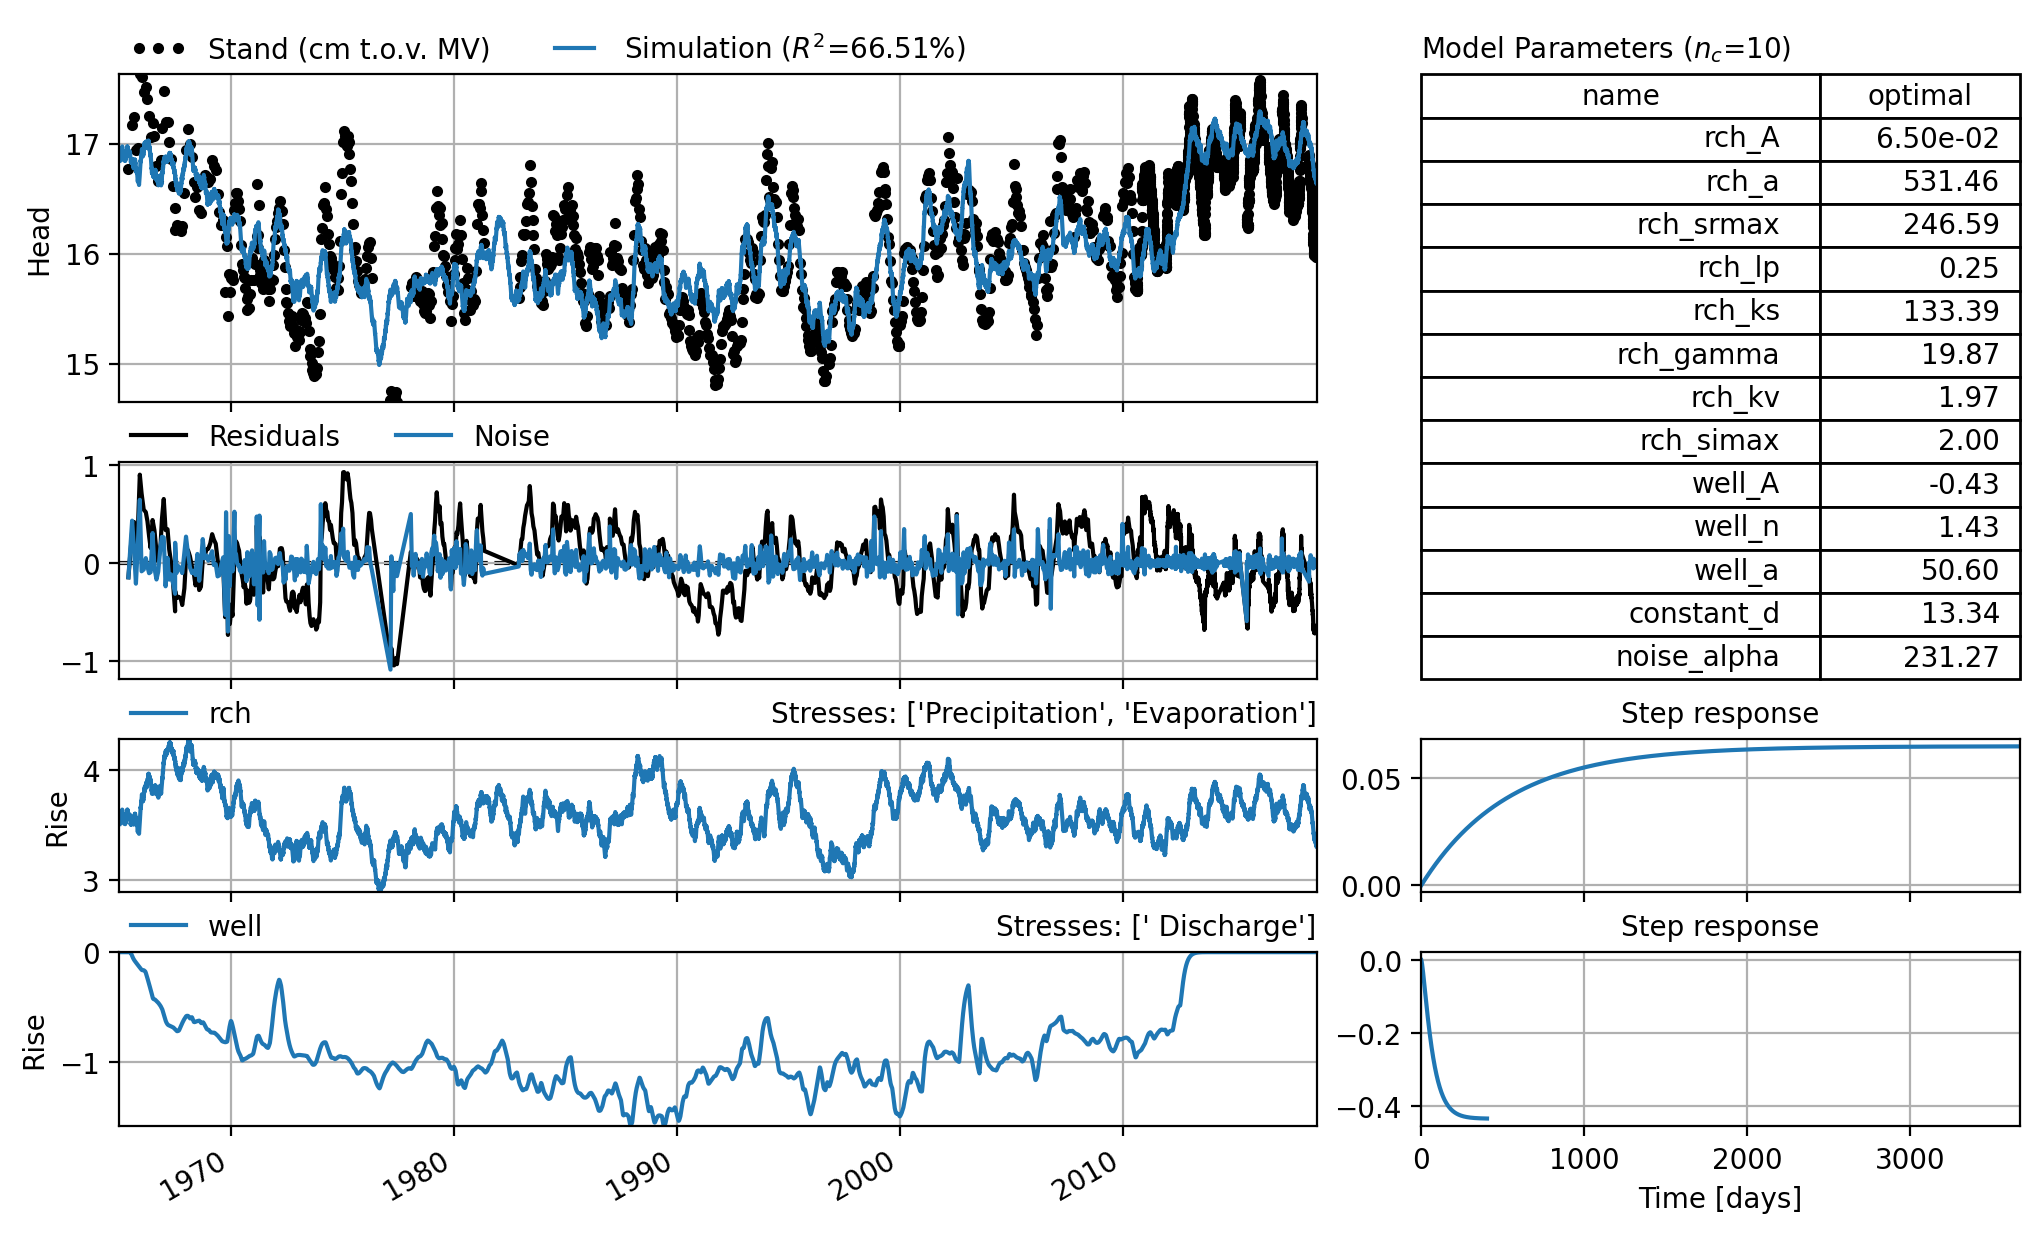

In [77]:
sm = ps.StressModel(well, rfunc=ps.Gamma(), name="well",
                    settings="well", up=False)
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(initial=False, report=False,
         tmin="1965", fit_constant=fit_constant)
ml.plots.results(figsize=(10, 6))

# print((ml.stats.nse(weighted=True).round(2)**2).round(2))  # Want ongelijke tijdstappen

The figure above clearly shows that the model fit improves when groundwater abstraction is added to the model. This also provides the opportunity to estimate the impact of groundwater abstraction on the groundwater head.

The step response can give an indication of the expected lowering (or rise) in groundwater head due to an increase (or decrease) in the volume of water abstracted. In this model, a Gamma response function with three parameters was used. 

An alternative response function that can be used is the Hantush function. The following figure shows the model results when a Hantush response function is used for the abstraction.

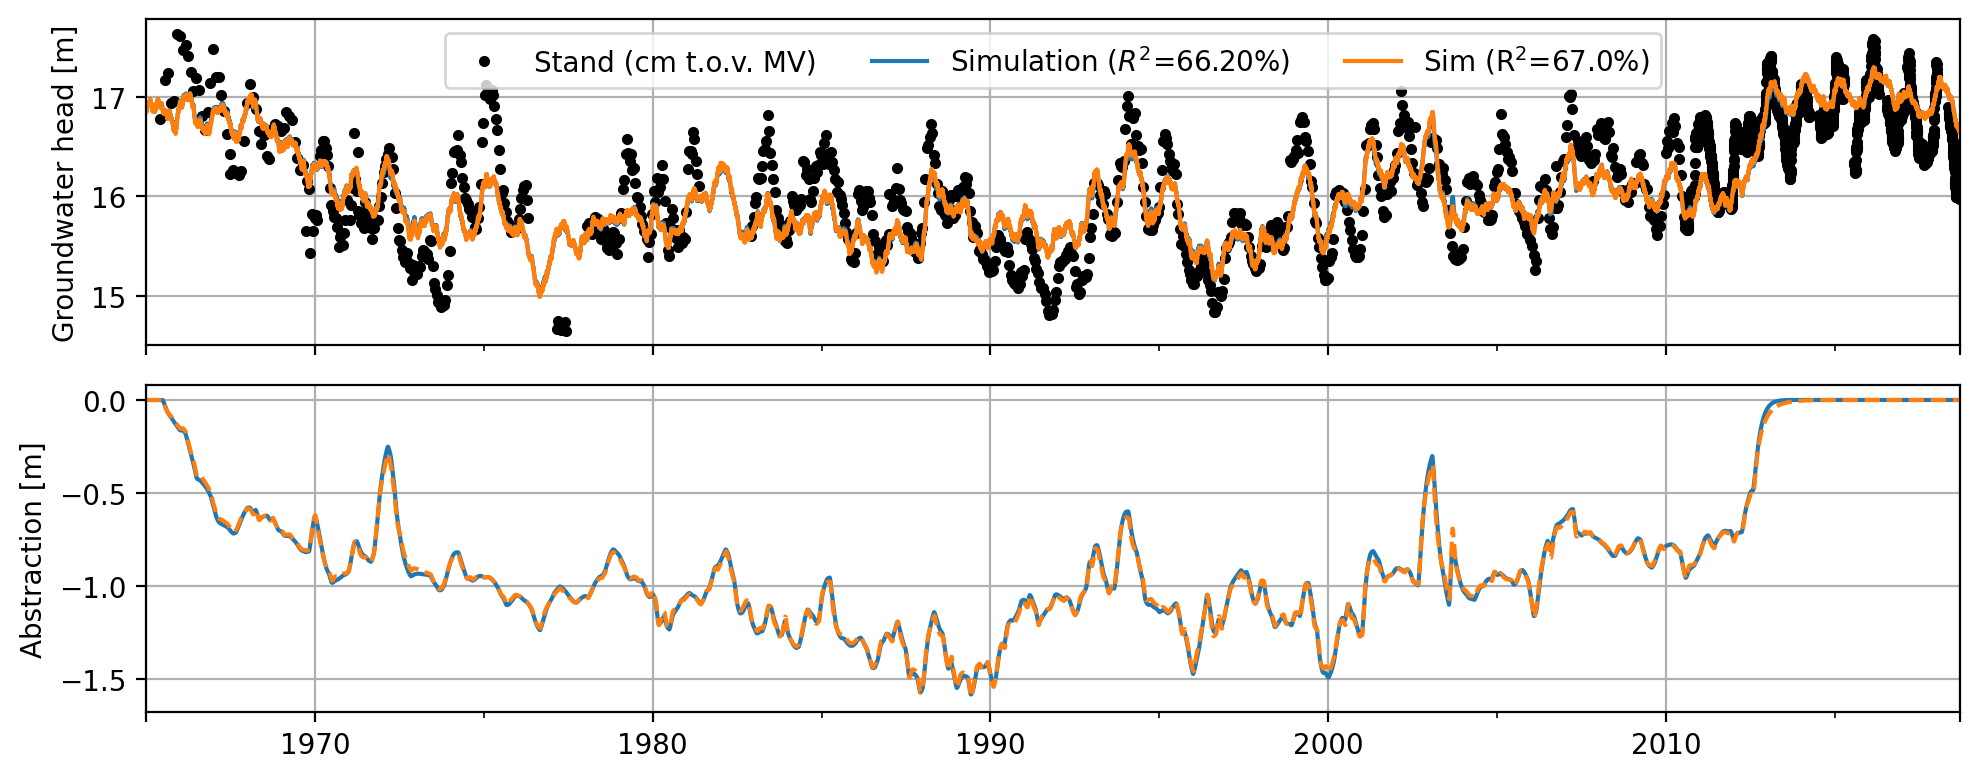

In [78]:
well1 = ml.get_contribution("well")
sim = ml.simulate()
sim.name = f"Sim (R$^2$={ml.stats.rsq().round(2)*100}%)"

ml.del_stressmodel("well")
sm = ps.StressModel(well, rfunc=ps.Hantush(), name="well",
                    settings="well", up=False)
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(initial=False, report=False,
         tmin="1965", fit_constant=fit_constant)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ml.plot(ax=ax1)
sim.plot(ax=ax1)

well1.plot(ax=ax2)
ml.get_contribution("well").plot(ax=ax2, linestyle="--")

ax1.legend(ncol=3)
ax1.grid()
ax2.grid()
ax1.set_ylabel("Groundwater head [m]")
ax2.set_ylabel("Abstraction [m]")
plt.tight_layout()

In this example, it makes little difference which of the two response functions is used to model the effect of the abstraction on the groundwater head.

Finally, a note on modeling abstractions and the variation in the discharge time series. To determine the impact of groundwater abstraction on the groundwater head, it is important that there is some variation present in the discharge time series. Unfortunately, there is (as yet) no rule of thumb for how much variation in an explanatory time series is sufficient to reliably determine its influence. For example, it is unknown whether the discharge series must include a period without abstraction in order to detect a rise in groundwater head caused by the shutdown of pumping.

It may also happen that discharge series follow a pattern similar to other time series (e.g., precipitation surplus and increased drinking water demand in summer), making it difficult to distinguish between these influences. For examples, see [Maas, 2011](#References) and [Baggelaar et al., 2018](#References).

### Multiple Groundwater Abstractions

When multiple pumping stations are present in an area, it is likely that the discharge series are strongly correlated. In such cases, it becomes difficult to distinguish their individual contributions. A possible solution is to translate the abstractions into groundwater head fluctuations using a single response function, scaled by the distance between the pumping well and the observation well. A model of this kind has been described, for instance, in [Berendrecht et al. (2006)](#References). 

This reduces the number of parameters to estimate, while often maintaining a similar model fit. Therefore, when working with multiple abstractions from the same aquifer, it is recommended to use such a model structure to keep the number of parameters as low as possible. This approach is illustrated in the example below.

---

The observation well is located 2,282 meters from pumping well 1 and 2,784 meters from pumping well 2. The abstraction discharge series are moderately correlated ($r = 0.65$). Both abstractions occur within the same aquifer. The responses of the groundwater head to the two abstractions are therefore expected to be related. The model described above is applied to this example below.

In [23]:
head = pd.read_csv("data/mw_head.csv", index_col=0, parse_dates=True).iloc[:, 0]
prec = pd.read_csv("data/mw_prec.csv", index_col=0, parse_dates=True).iloc[:, 0]
evap = pd.read_csv("data/mw_evap.csv", index_col=0, parse_dates=True).iloc[:, 0]
well1 = pd.read_csv("data/mw_well1.csv", index_col=0, parse_dates=True).iloc[:, 0] / 1e6
well2 = pd.read_csv("data/mw_well2.csv", index_col=0, parse_dates=True).iloc[:, 0] / 1e6

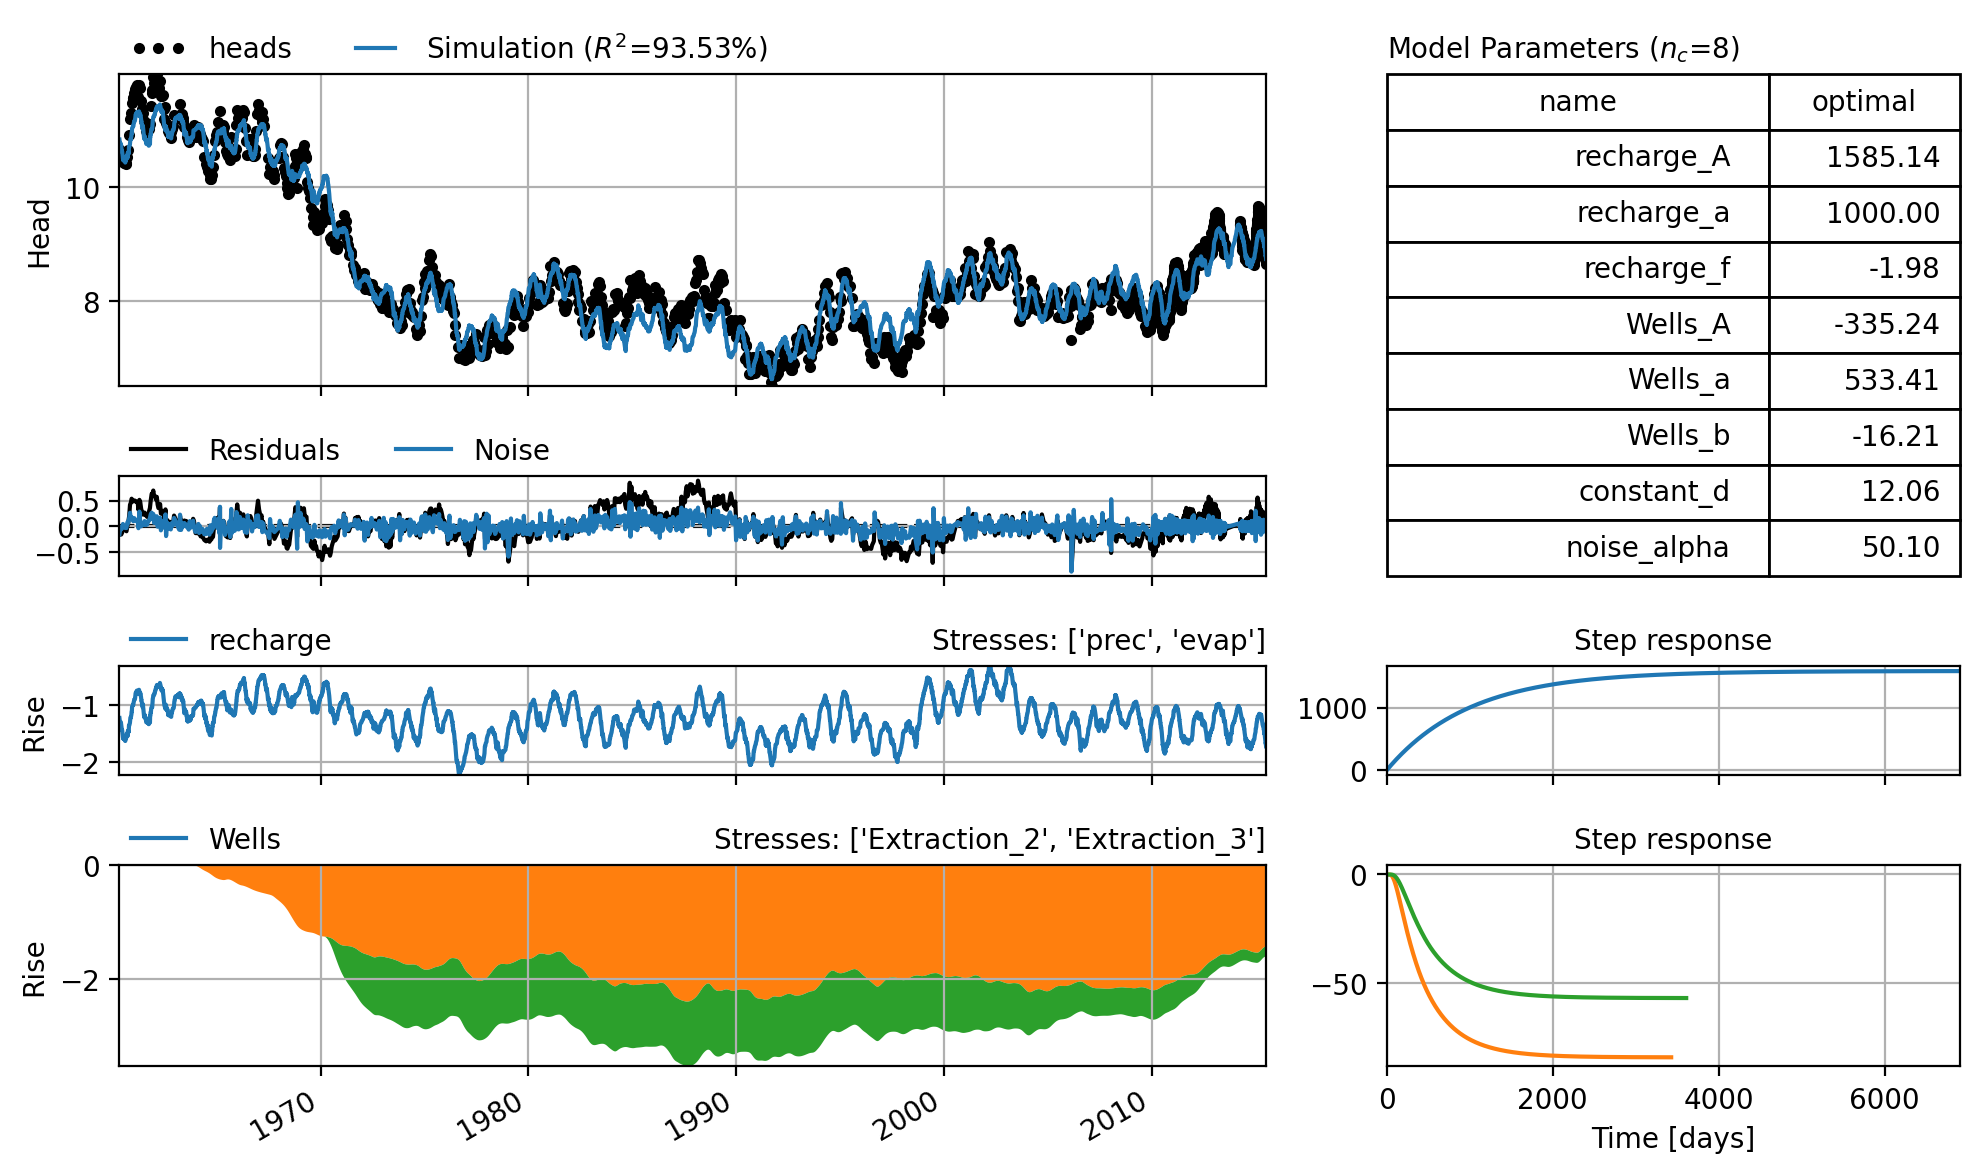

In [24]:
ml = ps.Model(head)

sm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Exponential())
distances = [2282, 2784]  # Afstanden van peilbuis tot pomputten
w = ps.WellModel(
    [well1, well2],
    name="Wells",
    distances=distances,
    settings="well",
    rfunc=ps.HantushWellModel()
)

ml.add_stressmodel([sm, w])
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(report=False, fit_constant=fit_constant)
ml.plots.stacked_results(figsize=(10, 6), adjust_height=True)
plt.tight_layout()

As shown in the figure above, the model is able to simulate the groundwater head well, while keeping the number of estimated parameters low (n = 8). When multiple abstractions are present in an area, it is advisable to use such a model structure to keep the number of parameters to be estimated limited.

## System Changes

Changes in groundwater head fluctuations do not always need to be modeled using an explanatory time series. There are many types of influences for which no time series of the change is available, but a qualitative description or timing of the change is known. Examples include a change in surface water levels in a polder where no measurements are available, a shift in vegetation type during the observation period, or gradual clogging of the riverbed, resulting in a changing response to fluctuations in surface water levels over time. Broadly, three methods can be used to account for such changes:

- Adding a linear trend over a specific period,
- Adding a step trend for an instantaneous change,
- Using a response function that changes over time.

### Step Trend

A one-time intervention in the water system can be modeled using a step trend [(see e.g. von Asmuth et al., 2012)](#References). A step trend can be used when a change in water level management has occurred that affects the groundwater head. This can be modeled as an abrupt increase (when the groundwater head responds quickly) or as a more gradual rise (when the groundwater system reacts more slowly). Different response functions can be used to describe how the groundwater head responds to such a change.

#### Example: Well B51G215

An example of such a model is shown for screen 1 of observation well B51G2150. In this case, the step trend is modeled as instantaneous (using a response function with no delay), and the height of the step trend is a calibration parameter. In this example, the estimated step trend (parameter $step_d$) is -0.40 meters, with a standard error of ±0.10 meters. For more information on interpreting and using the calculated step trend in further analysis, see [Knotters et al. (2020)](#References).


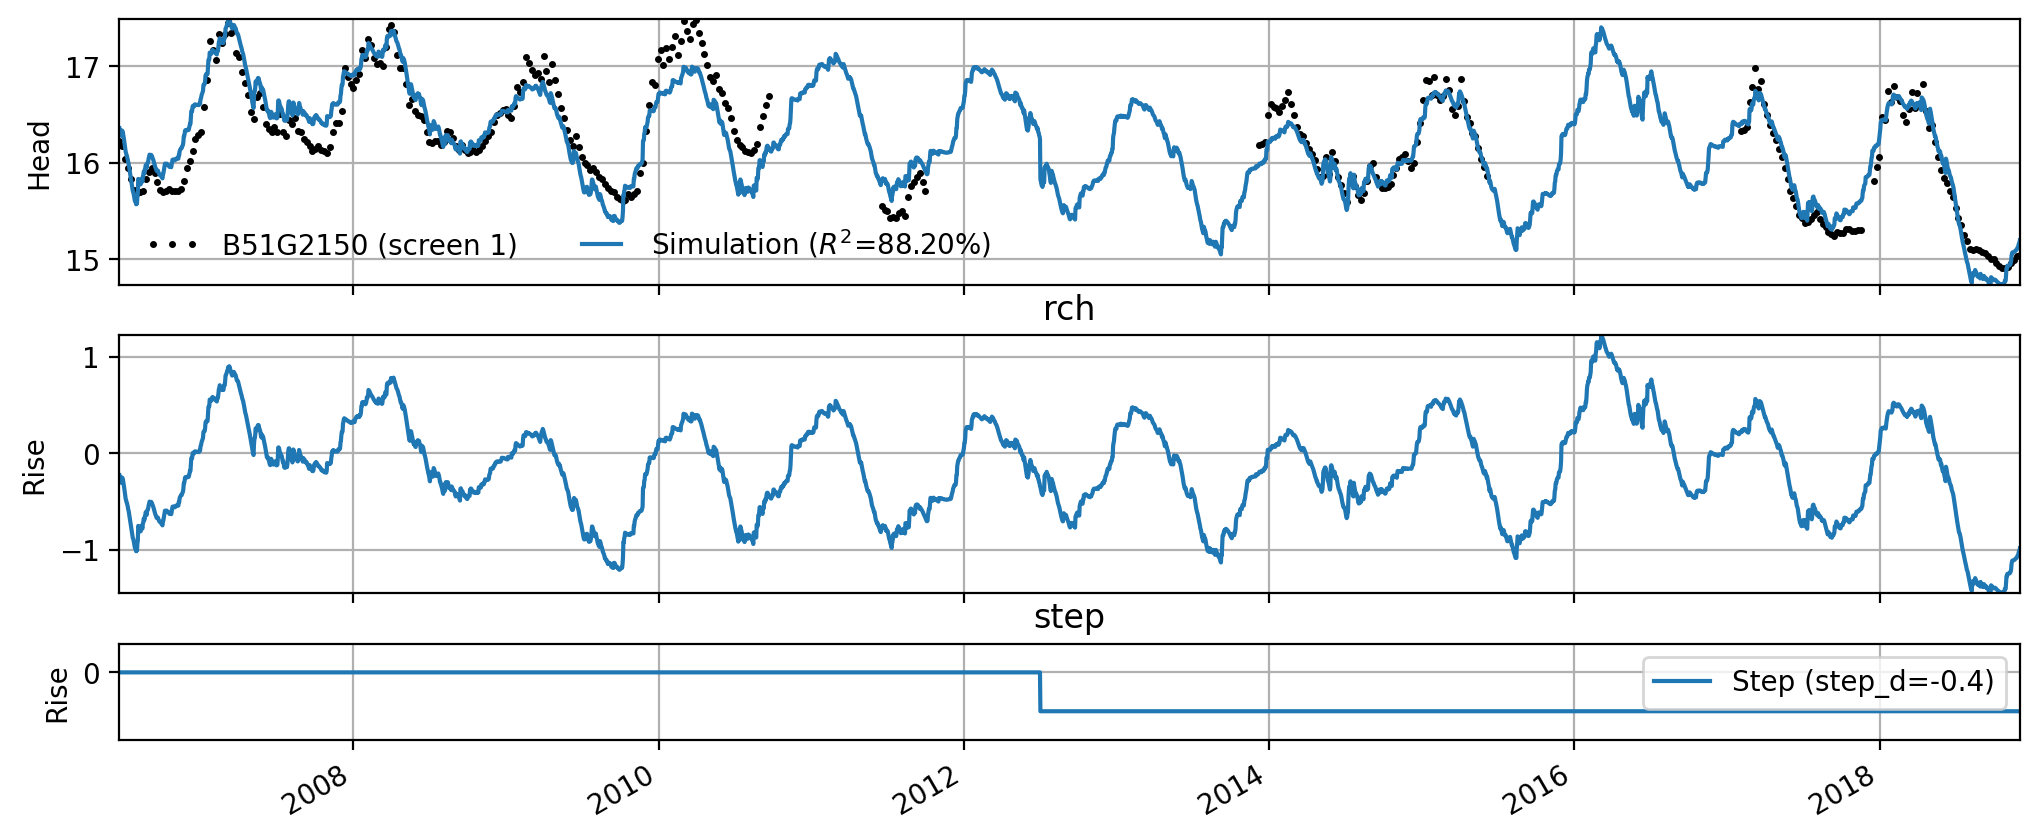

In [25]:
# Example of a model with step response
p = pd.read_csv("data/RD Helmond.csv", index_col=0, parse_dates=True).iloc[:, 0] * 1e3
e = pd.read_csv("data/EV24 Eindhoven.csv", index_col=0, parse_dates=True).iloc[:, 0] * 1e3
h = pd.read_csv("data/B51G2150-001.csv", index_col=0, parse_dates=True).iloc[:, 0]

h.name = "B51G2150 (screen 1)"

# Create a model
ml = ps.Model(h.iloc[::7])  # Daily observations, so we skip some to reduce computation.

# Add stress models
sm = ps.RechargeModel(p, e, name="rch", rfunc=ps.Exponential(),
                      recharge=ps.rch.Linear())
step = ps.StepModel(tstart=pd.Timestamp("2012-07-01"), name="step", up=None)
ml.add_stressmodel([sm, step])
ml.add_noisemodel(ps.ArNoiseModel())

# Calibrate the model and show the results
ml.solve(report=False, fit_constant=fit_constant)
axes = ml.plots.decomposition(figsize=(10, 4), min_ylim_diff=1, split=False)
axes[-1].legend([f"Step (step_d={ml.parameters.loc['step_d', 'optimal'].round(2)})"])

# ml.plots.diagnostics()  # Run to check that the noise is approximately white noise


### Example of a Model with Linear Trend

It often happens that a groundwater head time series shows an upward or downward trend that cannot be explained by precipitation or evaporation. In many cases, it is difficult to pinpoint a specific cause for the increase or decrease. For instance, the type of vegetation—and therefore the evaporation and groundwater recharge—may have changed over time. However, quantifying such an effect and incorporating it into the model is challenging. What is certain, though, is that without including the trend in the model, it becomes difficult to properly simulate the groundwater head.

#### Example: Well B32C0609

Here we examine a model for screen 1 of observation well B32C0609 near De Bilt. As a first step, we build a model with precipitation and evaporation as explanatory variables. This results in the following model.

[//]: # (WHAT IS THE IMPACT OF HIGH-FREQUENCY MEASUREMENTS HERE?)


Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.Columns (2,3,4,5,6,7,8,13,15,16,18,19,20,21,22,23,25,26,28,30,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.

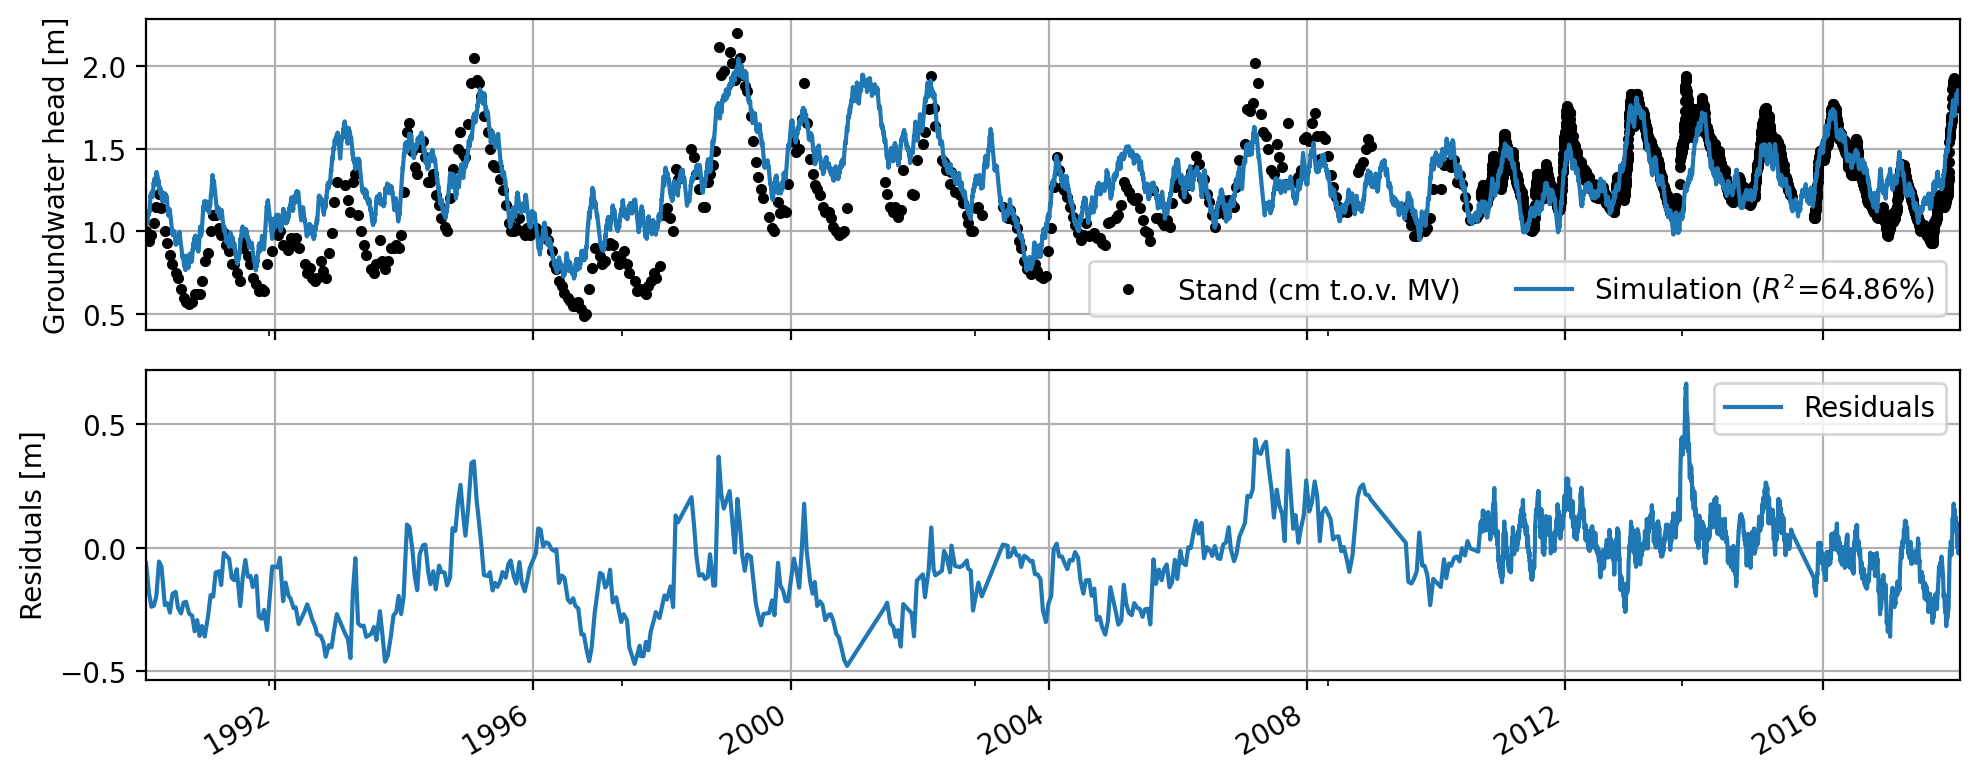

In [89]:
# Loads heads and create Pastas model

head2 = pd.read_csv('data/B32C0609001_1.csv', skiprows=15, index_col=2, parse_dates=True).iloc[:, 4].astype(float)/100
raw = pd.read_csv('data/etmgeg_260.txt', skiprows=47, index_col=1, parse_dates=True).replace("     ", np.nan)


rain = pd.to_numeric(raw['   RH']) *1e3
evap = pd.to_numeric(raw[' EV24']) *1e3

rain.name = "Precipitation"
evap.name = "Evaporation"

ml2 = ps.Model(head2, name="B32C0609 (filter 1)")

# Add a recharge model
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain, evap, recharge=rch,
                      rfunc=ps.Exponential(), name="rch")
ml2.add_stressmodel(rm)
#ml2.add_noisemodel(ps.ArNoiseModel())
# Solve and plot the model
ml2.solve(tmin="1990", report=False, fit_constant=fit_constant)

# Plot het model
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ml2.plot(ax=ax1)
ml2.residuals().plot(ax=ax2)
ax1.grid()
ax1.set_ylabel("Groundwater head [m]")
ax1.legend(["B32C0609 (filter 1)"])
ax2.grid()
ax2.set_ylabel("Residuals [m]")
ax2.legend(["Residuals"])
ax1.legend(ncol=3)
plt.tight_layout()

In the figure above, the result of the modeling is shown. We see that the model is generally able to explain the fluctuations in the observed groundwater level well, but the residuals of the model show a clear upward trend. The model overestimates the groundwater level at the beginning of the calibration period and underestimates it at the end of this period.

From the hydrological system analysis, it was concluded that there is likely no groundwater extraction taking place near the observation well. Therefore, an exact cause of the trend in the residuals cannot be identified. In this case, it may be useful to add a linear trend to the model in order to improve the simulation of the groundwater level. The result of this is shown below.

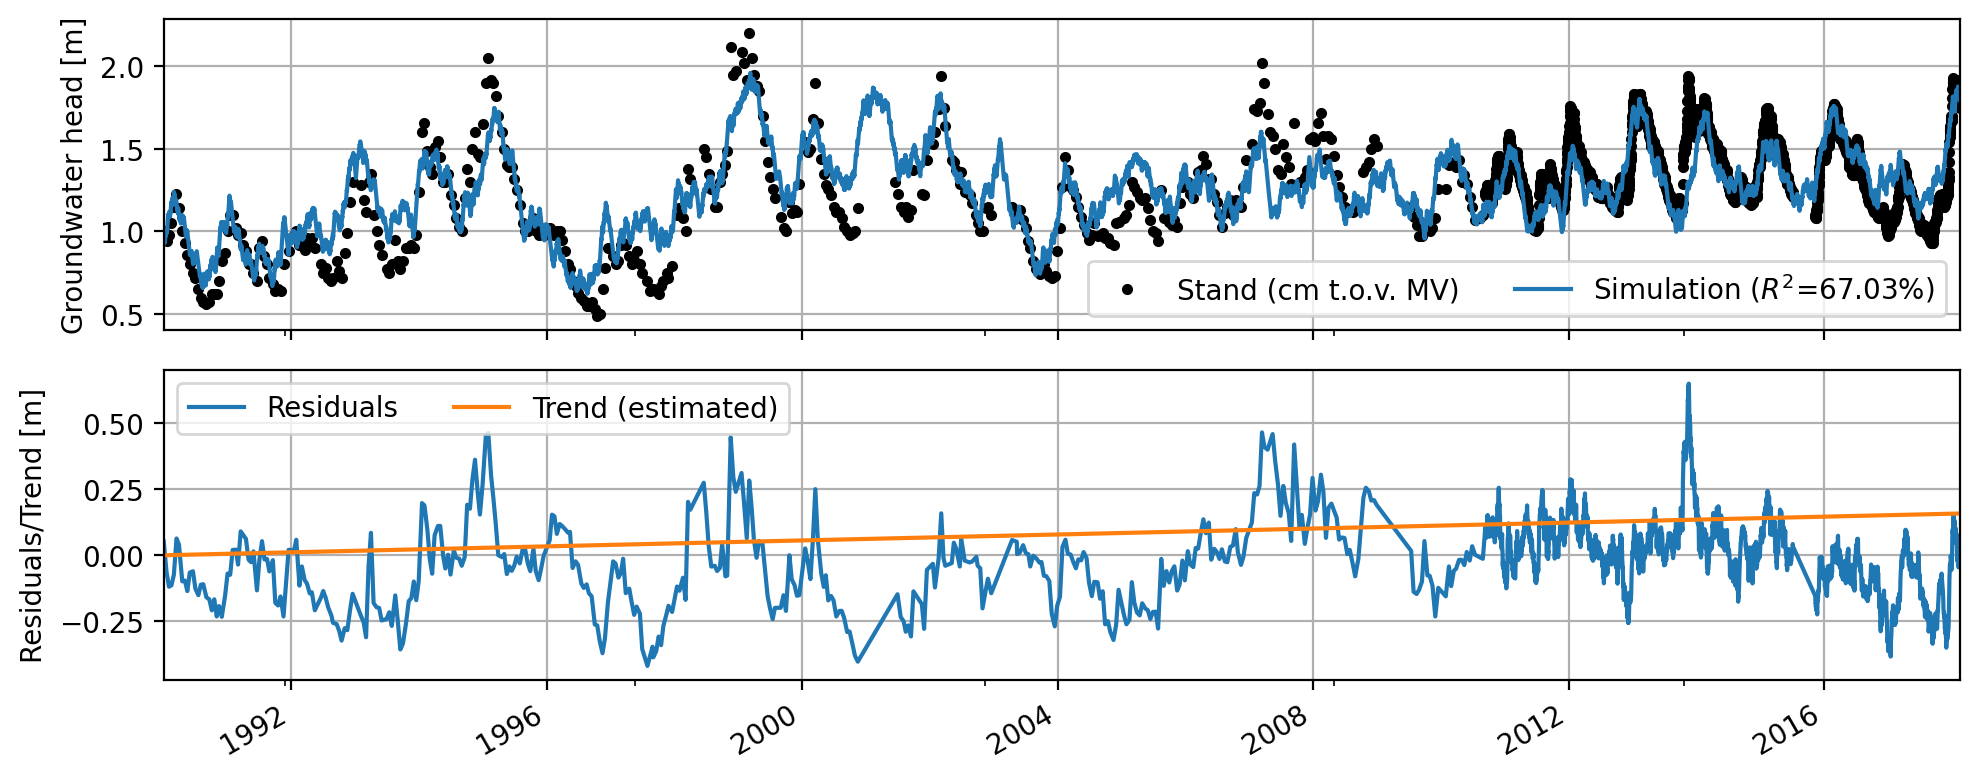

In [90]:
# Add a linear trend
tm = ps.LinearTrend(start="1990", end="2018", name="trend")
ml2.add_stressmodel(tm)

# Solve the model
ml2.solve(tmin="1990", initial=False,
          report=False, fit_constant=fit_constant)

# Plot het model
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ml2.plot(ax=ax1)
ml2.residuals().plot(ax=ax2)
ml2.get_contribution("trend").plot(ax=ax2)
ax1.grid()
ax1.set_ylabel("Groundwater head [m]")
ax1.legend(["B32C0609 (filter 1)"])
ax2.grid()
ax2.set_ylabel("Residuals/Trend [m]")
r2 = round(ml2.stats.rsq() * 100, 1)
ax1.legend(ncol=3)
ax2.legend(["Residuals", "Trend (estimated)"], ncol=2)
plt.tight_layout()

The figure above clearly shows an improvement in the simulation of the groundwater head by adding a trend. It is up to the modeler to choose a start and end date, or to add a trend for the entire observation period (as done here). This depends on the purpose of the modeling and the knowledge of the system and the underlying cause of the trend.

### Change in the response function over time

Up to this point in the notebook, it was assumed that the shape of the response function does not change over time. Although this assumption often works well, there are situations where it does not. [Obergfell et al. (2019)](#References), for example, looked at a case where the riverbed was dredged, causing the response of the groundwater head to changes in the river water level to change over time. They developed a model in which the shape of the response function evolves over time.


## Discussion

This notebook aimed to provide an overview of various model structures commonly used in the Netherlands. It is recommended to test multiple model structures for simulating groundwater head before selecting a final model. In general, it is relatively easy to vary model structures to, for example, reduce the number of parameters or improve the fit. Moreover, it is also possible to use multiple models. Such a multi-model approach can give a better estimate of model uncertainty resulting from model structure [(see e.g., Singh et al., 2010 and Ferré, 2017)](#References). While this can be time-consuming for numerical groundwater models, it is relatively easy to apply multiple models when using time series models.

Although this notebook attempted to present a comprehensive overview of possible model structures, it should be emphasized that it is relatively straightforward to develop new structures tailored to specific situations. This notebook used time series with different measurement frequencies. A time series with a higher measurement frequency may contain more information about processes that are not visible at lower frequencies [(see e.g., Herwijnen, 2001 and Berendrecht et al. 2003)](#References). On the other hand, many groundwater systems respond so slowly that low-frequency measurements contain sufficient information. The relationship between measurement frequency and the information content of a time series is part of ongoing research and should be considered when selecting a model structure.

## References

- Baggelaar, P.K., Niet, A.C., Jaarsma, N., Ek, R., van Vught, A.C. (2018) Evaluatie reallocatie Mander. Witteveen+Bos, Amsterdam.
- Berendrecht, W., Gehrels, H., van Geer, F., & Heemink, A. (2003) Tijdreeksanalyse kan veel beter door kleiner modelinterval. Stromingen 9, No. 1.
- Berendrecht, W., Gehrels, H., van Geer, F., & Heemink, A. (2004) Een niet-lineair tijdreeksmodel voor grondwaterstandsfluctuaties in gedraineerde gebieden. Stromingen 10, No. 2.
- Berendrecht, W. L., Heemink, A. W., Van Geer, F. C., & Gehrels, J. C. (2006). A non-linear state space approach to model groundwater fluctuations. Advances in Water Resources, 29(7), 959–973.
- Collenteur, R., Bakker, M., Klammler, G., & Birk, S. (2020). Estimating groundwater recharge from groundwater levels using non-linear transfer function noise models and comparison to lysimeter data. Hydrology and Earth System Sciences Discussions, 1–30.
- Ferré, T.P. (2017). Revisiting the Relationship Between Data, Models, and Decision‐Making. Groundwater, 55: 604–614.
- Knotters, M., & De Gooijer, J.G. (1999). TARSO modeling of water table depths. Water Resources Research, 35(3).
- Knotters, M., Baggelaar, P.K., & Van der Meulen, E. (2020). Hoezo significant? Over het effect van een ingreep op de grondwaterstand. Stromingen 26, No. 3.
- Maas, C. (2011). Grondwatermodellen versus Tijdreeksanalyse. KWR, Nieuwegein.
- Obergfell, C., Bakker, M., & Maas, K. (2019). Identification and explanation of a change in the groundwater regime using time series analysis. Groundwater, 57(6), 886–894.
- Peterson, T. J., & Western, A. W. (2014). Nonlinear time‐series modeling of unconfined groundwater head. Water Resources Research, 50(10), 8330–8355.
- Singh, A., Mishra, S., & Ruskauff, G. (2010). Model Averaging Techniques for Quantifying Conceptual Model Uncertainty. Groundwater, 48: 701–715.
- Van Herwijnen, T. (2002). Tijdreeksanalyse van grondwaterpeilen: invloed van het meetinterval. Stromingen 8, No. 4.
- Von Asmuth, J. R., Bierkens, M. F., & Maas, K. (2002). Transfer function‐noise modeling in continuous time using predefined impulse response functions. Water Resources Research, 38(12), 23-1.
- Von Asmuth, J. R., Maas, K., Knotters, M., Bierkens, M. F., Bakker, M., Olsthoorn, T. N., Cirkel, D.G., Leunk, I., & Von Asmuth, D. C. (2012). Software for hydrogeologic time series analysis, interfacing data with physical insight. Environmental Modelling & Software, 38, 178–190.
- Von Asmuth, J., Van der Schaaf, S., Grootjans, A., & Maas, K. (2012). Vennen en veentjes: (niet-)ideale systemen voor niet-lineaire tijdreeksmodellen. Stromingen 18, No. 2.
